In [3]:
#Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
from datetime import datetime
import datetime
import time
import timestring
import math
import scipy
import os
matplotlib.rcParams['figure.figsize'] = (14, 8)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-the-dataset" data-toc-modified-id="Import-the-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import the dataset</a></span><ul class="toc-item"><li><span><a href="#Split-the-data-into-appropriate-delay-intervals" data-toc-modified-id="Split-the-data-into-appropriate-delay-intervals-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Split the data into appropriate delay intervals</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-Arrival-Delays-for-all-flights-(includes-negative-values-for-early-flights)" data-toc-modified-id="Distribution-of-Arrival-Delays-for-all-flights-(includes-negative-values-for-early-flights)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Distribution of Arrival Delays for all flights (includes negative values for early flights)</a></span></li><li><span><a href="#Distribution-of-long-flights-vs-short-flights" data-toc-modified-id="Distribution-of-long-flights-vs-short-flights-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Distribution of long flights vs short flights</a></span></li><li><span><a href="#Distribution-of-delayed-flights-by-airline:" data-toc-modified-id="Distribution-of-delayed-flights-by-airline:-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Distribution of delayed flights by airline:</a></span></li><li><span><a href="#A-glimpse-at-the-carrier-performance-throughout-the-year" data-toc-modified-id="A-glimpse-at-the-carrier-performance-throughout-the-year-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>A glimpse at the carrier performance throughout the year</a></span><ul class="toc-item"><li><span><a href="#Let's-visualize-arrival-delay-distribution-by-carrier." data-toc-modified-id="Let's-visualize-arrival-delay-distribution-by-carrier.-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Let's visualize arrival delay distribution by carrier.</a></span></li><li><span><a href="#Conclusion-and-summaries" data-toc-modified-id="Conclusion-and-summaries-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Conclusion and summaries</a></span></li></ul></li><li><span><a href="#Delays-by-airport" data-toc-modified-id="Delays-by-airport-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Delays by airport</a></span></li><li><span><a href="#Regional-Analysis" data-toc-modified-id="Regional-Analysis-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Regional Analysis</a></span><ul class="toc-item"><li><span><a href="#FAA-has-data-available-for-NAS-delays,-further-broken-down-by-category." data-toc-modified-id="FAA-has-data-available-for-NAS-delays,-further-broken-down-by-category.-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>FAA has data available for NAS delays, further broken down by category.</a></span></li></ul></li><li><span><a href="#Evaluating-congested-times-in-a-selected-region" data-toc-modified-id="Evaluating-congested-times-in-a-selected-region-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Evaluating congested times in a selected region</a></span><ul class="toc-item"><li><span><a href="#Do-busy-times-in-a-given-region-have-a-higher-arrival-delay-time?" data-toc-modified-id="Do-busy-times-in-a-given-region-have-a-higher-arrival-delay-time?-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Do busy times in a given region have a higher arrival delay time?</a></span></li><li><span><a href="#Total-air-traffic-dataframe" data-toc-modified-id="Total-air-traffic-dataframe-2.7.2"><span class="toc-item-num">2.7.2&nbsp;&nbsp;</span>Total air traffic dataframe</a></span></li></ul></li><li><span><a href="#Most-Delayed-and-Most-On-Time-Routes-by-Airline-(Weighted-Average)" data-toc-modified-id="Most-Delayed-and-Most-On-Time-Routes-by-Airline-(Weighted-Average)-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Most Delayed and Most On-Time Routes by Airline (Weighted Average)</a></span><ul class="toc-item"><li><span><a href="#United-Airlines-(Weighted-Average)" data-toc-modified-id="United-Airlines-(Weighted-Average)-2.8.1"><span class="toc-item-num">2.8.1&nbsp;&nbsp;</span>United Airlines (Weighted Average)</a></span><ul class="toc-item"><li><span><a href="#Delayed-most-common-airport-origin-and-destination" data-toc-modified-id="Delayed-most-common-airport-origin-and-destination-2.8.1.1"><span class="toc-item-num">2.8.1.1&nbsp;&nbsp;</span>Delayed most common airport origin and destination</a></span></li><li><span><a href="#On-time-most-common-airport-origin-and-destination" data-toc-modified-id="On-time-most-common-airport-origin-and-destination-2.8.1.2"><span class="toc-item-num">2.8.1.2&nbsp;&nbsp;</span>On-time most common airport origin and destination</a></span></li></ul></li><li><span><a href="#Delta-Airlines-(Weighted-Average)" data-toc-modified-id="Delta-Airlines-(Weighted-Average)-2.8.2"><span class="toc-item-num">2.8.2&nbsp;&nbsp;</span>Delta Airlines (Weighted Average)</a></span></li></ul></li><li><span><a href="#Compare-NYC-Bay-Area-flights-(and-back)" data-toc-modified-id="Compare-NYC-Bay-Area-flights-(and-back)-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Compare NYC-Bay Area flights (and back)</a></span></li></ul></li></ul></div>

# Import the dataset

In [4]:
year = '2017'

In [5]:
#read in the csv file for desired year
df = pd.read_csv(f'./Data/{year}ALL.csv')

In [6]:
#remove rows will null values which is approximately 1.5%
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Tail_Number               12511
DepTime                   80308
DepDelay                  80343
DepartureDelayGroups      80343
TaxiOut                   82145
WheelsOff                 82141
WheelsOn                  84674
TaxiIn                    84674
ArrTime                   84674
ArrDelay                  95211
CRSElapsedTime                7
ActualElapsedTime         95211
AirTime                   95211
CarrierDelay            4645148
WeatherDelay            4645148
NASDelay                4645148
SecurityDelay           4645148
LateAircraftDelay       4645148
dtype: int64

In [7]:
df = df.dropna(subset=['Tail_Number','DepTime','DepDelay','DepartureDelayGroups','TaxiOut',
                      'WheelsOff','WheelsOn','TaxiIn','ArrTime','ArrDelay','CRSElapsedTime',
                      'ActualElapsedTime','AirTime'])

df = df.fillna(0)

In [8]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 100)
pd.set_option('display.max_info_columns', 200)

In [9]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,Dest,DestCityName,DestState,CRSDepTime,DepTime,DepDelay,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrTimeBlk,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2017,2,5,6,6,2017-05-06,WN,N7824A,4652,14831,1483104,32457,SJC,"San Jose, CA",CA,SAN,"San Diego, CA",CA,650,649.0,-1.0,-1.0,0600-0659,12.0,701.0,808.0,4.0,810,812.0,2.0,0800-0859,80.0,83.0,67.0,1.0,417.0,2,0.0,0.0,0.0,0.0,0.0
1,2017,2,5,6,6,2017-05-06,WN,N8522P,4971,14831,1483104,32457,SJC,"San Jose, CA",CA,SAN,"San Diego, CA",CA,1710,1705.0,-5.0,-1.0,1700-1759,9.0,1714.0,1820.0,3.0,1830,1823.0,-7.0,1800-1859,80.0,78.0,66.0,1.0,417.0,2,0.0,0.0,0.0,0.0,0.0
2,2017,2,5,6,6,2017-05-06,WN,N8617E,5113,14831,1483104,32457,SJC,"San Jose, CA",CA,SAN,"San Diego, CA",CA,1100,1100.0,0.0,0.0,1100-1159,11.0,1111.0,1216.0,4.0,1220,1220.0,0.0,1200-1259,80.0,80.0,65.0,1.0,417.0,2,0.0,0.0,0.0,0.0,0.0
3,2017,2,5,6,6,2017-05-06,WN,N450WN,5150,14831,1483104,32457,SJC,"San Jose, CA",CA,SAN,"San Diego, CA",CA,2030,2029.0,-1.0,-1.0,2000-2059,8.0,2037.0,2148.0,3.0,2150,2151.0,1.0,2100-2159,80.0,82.0,71.0,1.0,417.0,2,0.0,0.0,0.0,0.0,0.0
4,2017,2,5,6,6,2017-05-06,WN,N498WN,5711,14831,1483104,32457,SJC,"San Jose, CA",CA,SAN,"San Diego, CA",CA,1325,1324.0,-1.0,-1.0,1300-1359,8.0,1332.0,1439.0,4.0,1445,1443.0,-2.0,1400-1459,80.0,79.0,67.0,1.0,417.0,2,0.0,0.0,0.0,0.0,0.0


In [10]:
df = df[['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline',
       'Origin', 'OriginState', 'DestState', 'Dest', 'CRSDepTime','DepTime', 'DepDelay',
       'TaxiOut', 'TaxiIn', 'CRSArrTime','ArrTime', 'CRSElapsedTime',
       'ArrDelay', 'Distance', 'DistanceGroup','CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay']]
df = df.reset_index()

## Split the data into appropriate delay intervals

In [11]:
df.head()

,index,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,DestState,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,CRSArrTime,ArrTime,CRSElapsedTime,ArrDelay,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2,5,6,6,2017-05-06,WN,N7824A,4652,SJC,CA,CA,SAN,650,649.0,-1.0,12.0,4.0,810,812.0,80.0,2.0,417.0,2,0.0,0.0,0.0,0.0,0.0
1,1,2,5,6,6,2017-05-06,WN,N8522P,4971,SJC,CA,CA,SAN,1710,1705.0,-5.0,9.0,3.0,1830,1823.0,80.0,-7.0,417.0,2,0.0,0.0,0.0,0.0,0.0
2,2,2,5,6,6,2017-05-06,WN,N8617E,5113,SJC,CA,CA,SAN,1100,1100.0,0.0,11.0,4.0,1220,1220.0,80.0,0.0,417.0,2,0.0,0.0,0.0,0.0,0.0
3,3,2,5,6,6,2017-05-06,WN,N450WN,5150,SJC,CA,CA,SAN,2030,2029.0,-1.0,8.0,3.0,2150,2151.0,80.0,1.0,417.0,2,0.0,0.0,0.0,0.0,0.0
4,4,2,5,6,6,2017-05-06,WN,N498WN,5711,SJC,CA,CA,SAN,1325,1324.0,-1.0,8.0,4.0,1445,1443.0,80.0,-2.0,417.0,2,0.0,0.0,0.0,0.0,0.0


In [12]:
df.columns

Index(['index', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline',
       'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 'OriginState', 'DestState',
       'Dest', 'CRSDepTime', 'DepTime', 'DepDelay', 'TaxiOut', 'TaxiIn', 'CRSArrTime', 'ArrTime',
       'CRSElapsedTime', 'ArrDelay', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [13]:
#all arrival delays
delays = df[df.ArrDelay > 0]
#arrival delays more than 15 minutes
delays_15 = df[df.ArrDelay > 15]
#arrival delays longer than 4 hrs
delays_4hr = df[df.ArrDelay / 60 >=4]
#arrival delays more than 15mins and less than 4 hrs
delays_15_4 = df[(df.ArrDelay / 60 < 4) & (df.ArrDelay > 15)]

In [14]:
df.Month.count()

5579410

In [15]:
delays_15.Month.count()

992420

# EDA 

## Distribution of Arrival Delays for all flights (includes negative values for early flights)

(-100, 200)

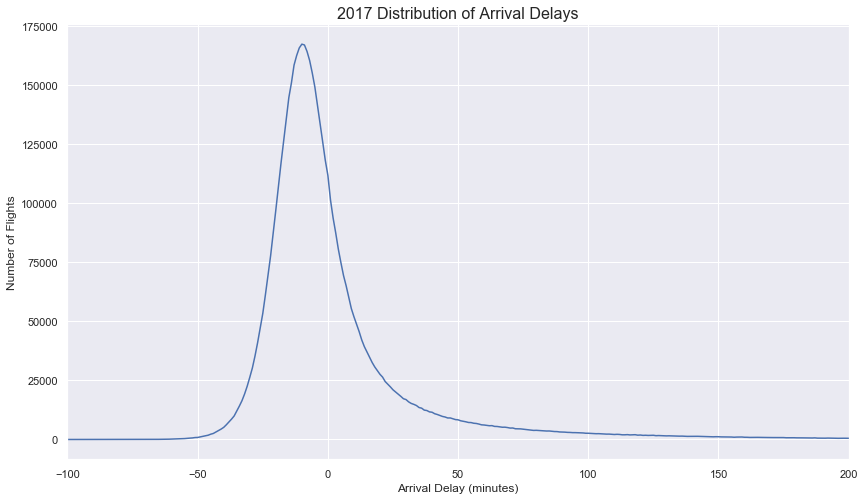

In [16]:
df.groupby('ArrDelay').size().plot()
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Number of Flights')
plt.title('2017 Distribution of Arrival Delays', fontsize=16)
plt.xlim(-100,200)

In [17]:
scipy.stats.skew(df['ArrDelay'])

8.647583607239195

## Distribution of long flights vs short flights

In [18]:
short_route = df[df.CRSElapsedTime < 180]
long_route = df[df.CRSElapsedTime >= 180]

Short flight average delay: 4.855978435519998
Long flight average delay: 2.7596414560262206


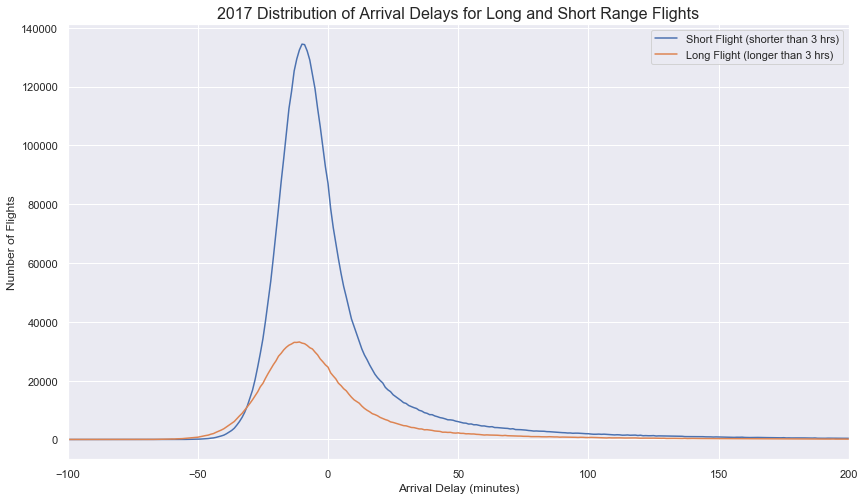

In [19]:
short_route.groupby('ArrDelay').size().plot()
long_route.groupby('ArrDelay').size().plot()
plt.xlim(-100,200)
plt.ylabel('Number of Flights')
plt.title('2017 Distribution of Arrival Delays for Long and Short Range Flights', fontsize=16)
plt.xlabel('Arrival Delay (minutes)')
plt.legend(['Short Flight (shorter than 3 hrs)', 'Long Flight (longer than 3 hrs)'])

print(f'Short flight average delay: {short_route.ArrDelay.mean()}')
print(f'Long flight average delay: {long_route.ArrDelay.mean()}')

The distribution of arrival delays is heavily skewed, with majority of the arrivals being on-time or early. 
One possible way to model the data is to classify if a flight will be delayed or not with a probability. Then we can use linear regreassion or random forrests to determine the length of delay

## Distribution of delayed flights by airline:

In [20]:
print(f'Arrival Delay Mean: {df.ArrDelay.mean()}')
print(f'Arrival Delay Median: {df.ArrDelay.median()}')
print(f'Arrival Delay Standard Deviation: {df.ArrDelay.std()}')

Arrival Delay Mean: 4.3263569087054
Arrival Delay Median: -6.0
Arrival Delay Standard Deviation: 45.86481472325204


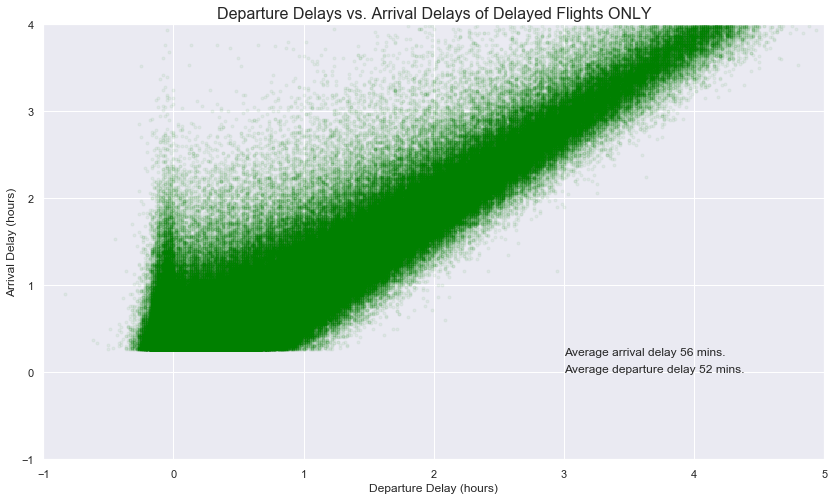

In [21]:
plt.plot(delays_15_4.DepDelay / 60, delays_15_4.ArrDelay / 60, marker='.',
         linestyle='None', alpha = 0.05, color='green')
plt.xlim([-1, 5])
plt.ylim([-1, 4])
plt.xlabel('Departure Delay (hours)')
plt.ylabel('Arrival Delay (hours)')
plt.text(3, 0, f"Average departure delay {round((delays_15_4.DepDelay).mean())} mins.")
plt.text(3, 0.2, f"Average arrival delay {round((delays_15_4.ArrDelay).mean())} mins.")
plt.title('Departure Delays vs. Arrival Delays of Delayed Flights ONLY', fontsize=16)
plt.show()

There is a distinct linear relationship between departure delay and arrival delay, which makes sense. This means  we can also analyze departure delays and causes to predict arrival delays. We also see a small spike around the area of early departure or on time departure but late arrival. This is most likely due to airlines trying to get out on time even though they may be impacted by traffic at the airport, air traffic controll, or even weather. As such, arrival time may still be impacted

## A glimpse at the carrier performance throughout the year

In [22]:
#split the data into delayed flights (>15min. on arrival per FAA) and non-delayed flights
#we then sort the data by index in order to be able to get a ratio of delayed flights
flights_by_carrier = df.groupby('Reporting_Airline').size().sort_index()
flights_by_carrier_del = delays_15.groupby('Reporting_Airline').size().sort_index()
percent_delay = flights_by_carrier_del / flights_by_carrier

sorted_flights = flights_by_carrier.sort_values(ascending=False)
sorted_flights_del = flights_by_carrier_del.sort_values(ascending=False)

#When creating above dataframes we need to make sure that they all have the same index values so we can
#visualize the data correctly.
####use the same index for all data####
sorted_flights_del = sorted_flights_del.get(sorted_flights.index)
percent_delay = percent_delay.get(sorted_flights.index)

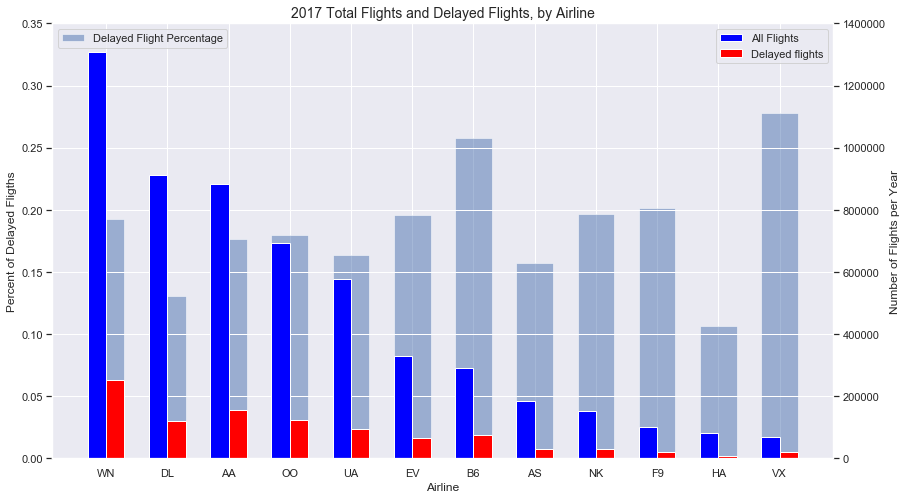

In [23]:
ax = plt.subplot(111)
ax.bar(sorted_flights.index, percent_delay, width=0.6, align='center', alpha=0.5)
plt.xlabel('Airline')
plt.ylabel('Percent of Delayed Fligths')
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.ylim(0,0.35)

ax2 = ax.twinx()
ax2.bar(sorted_flights.index, sorted_flights, width=-0.3, align='edge', color='blue')
ax2.bar(sorted_flights_del.index, sorted_flights_del, width=0.3, align='edge', color='red')
plt.legend(['All Flights', 'Delayed flights'])
plt.xlabel('Airline')
plt.ylabel('Number of Flights per Year')
plt.title(f'{year} Total Flights and Delayed Flights, by Airline', fontsize=14)
plt.ylim(0,1400000)
plt.show()

Above chart shows the total number of flights, delayed flights, and the ratio of delayed flights broken down by airline. We can break this down by individual airline and look at top airport and top region performance

In [24]:
#Airline codes with names for cleaner presentation
airline_codes = pd.read_csv('L_CARRIER_HISTORY.csv')
airline_dict = airline_codes.set_index('Code').to_dict()['Description']

### Let's visualize arrival delay distribution by carrier. 
We'll need to cap the arrival delay to 60 minutes to be able to view the data due to the extreme outliers.

In [25]:
#create a dataframe from existing data containing only the columns we need
df_carriers = df[['Reporting_Airline', 'Origin', 'Dest', 'ArrDelay']]

In [26]:
#add the airline names for easier interpretation 
df_carriers = pd.merge(df_carriers, airline_codes, how='left', left_on='Reporting_Airline', right_on='Code')

In [27]:
df_carriers['ArrDelay'] = df_carriers['ArrDelay'].apply(lambda x: 60 if x>=60 else x)
df_carriers['ArrDelay'] = df_carriers['ArrDelay'].apply(lambda x: -60 if x<=-60 else x)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


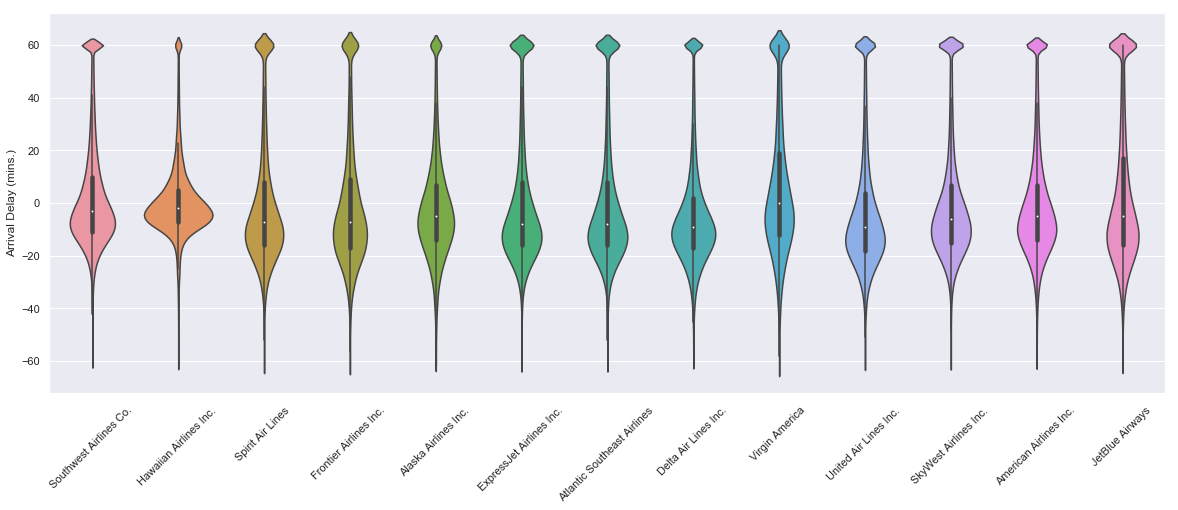

In [28]:
#visualize the data
plt.figure(figsize=(20,7))
ax = sns.violinplot(x='Description', y='ArrDelay', data=df_carriers)
ax.set_ylabel('Arrival Delay (mins.)')
ax.set_xlabel('')
label = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [29]:
percent_delay.index

Index(['WN', 'DL', 'AA', 'OO', 'UA', 'EV', 'B6', 'AS', 'NK', 'F9', 'HA', 'VX'], dtype='object', name='Reporting_Airline')

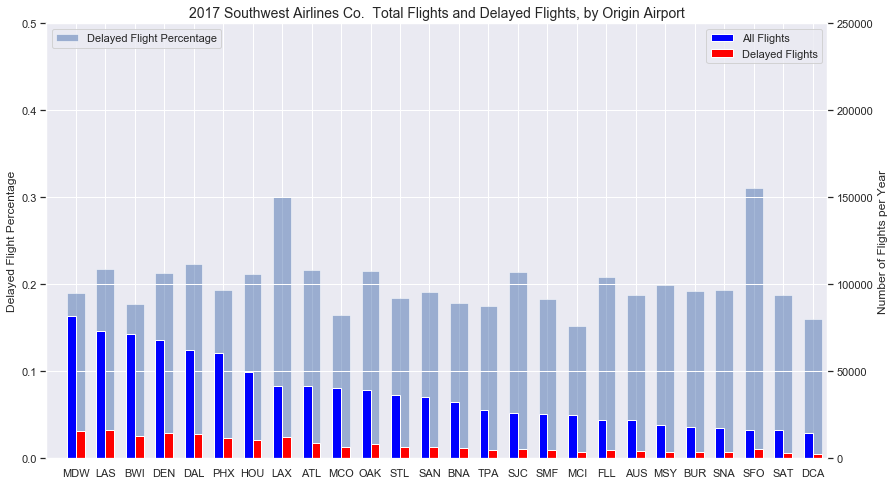

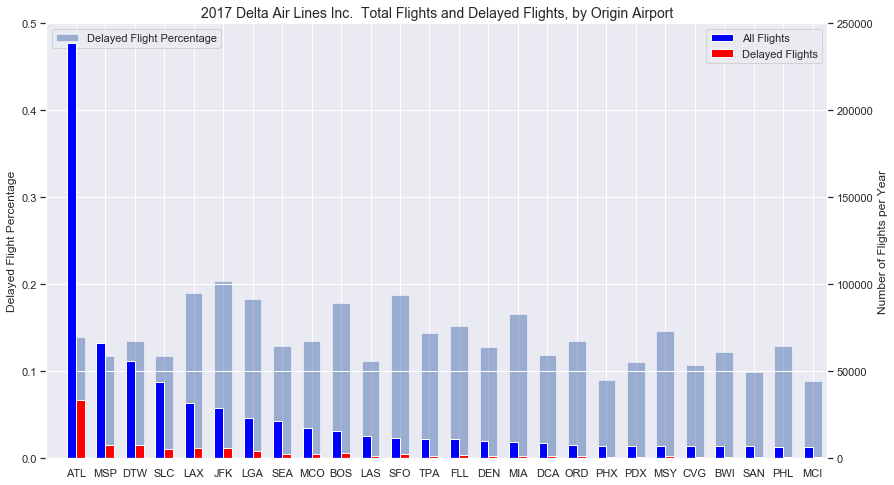

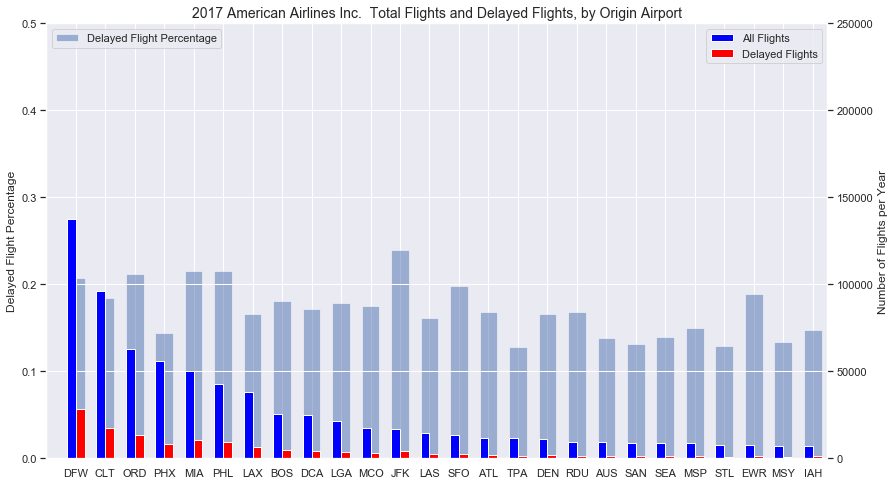

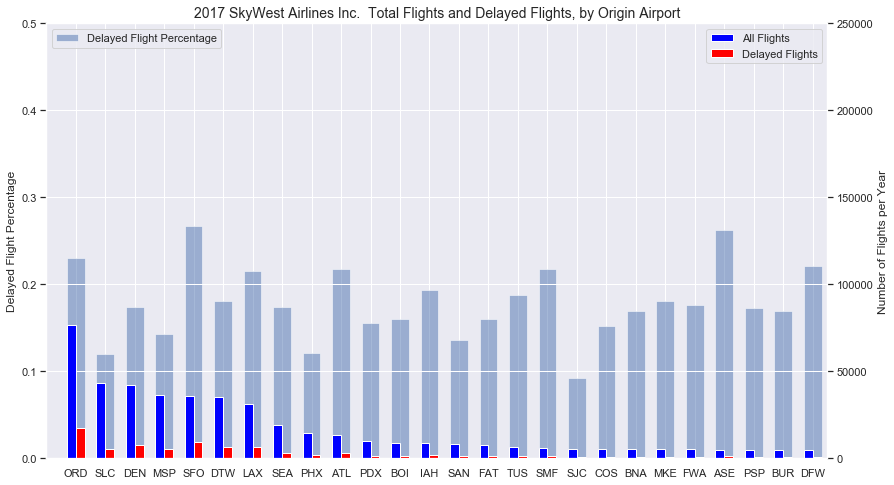

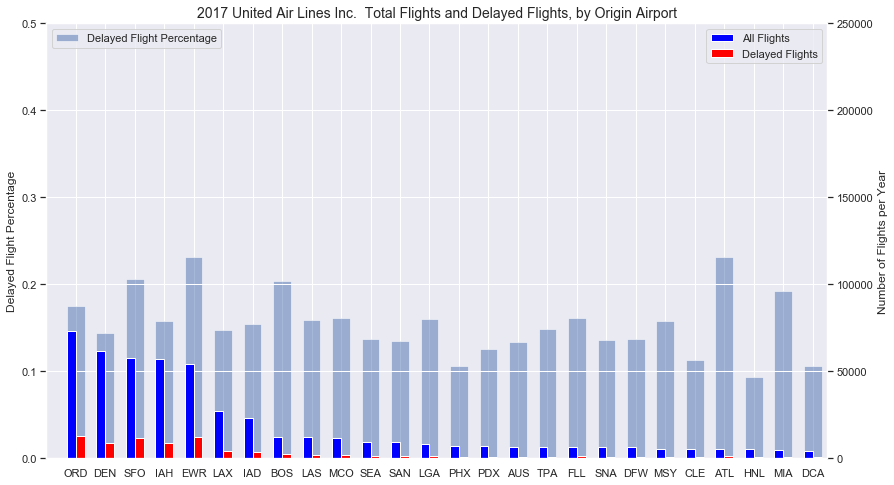

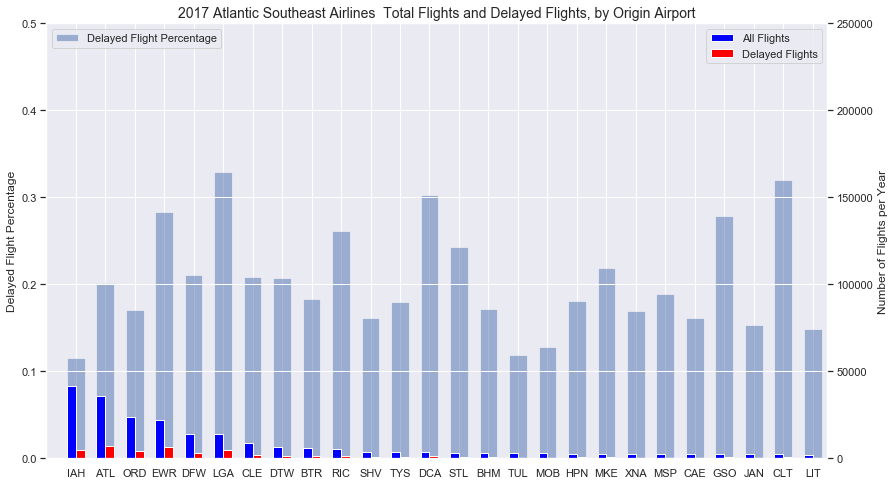

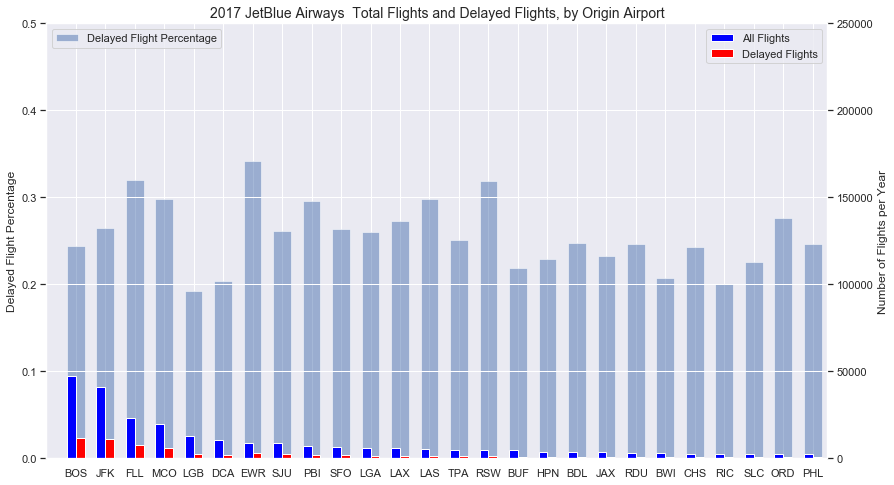

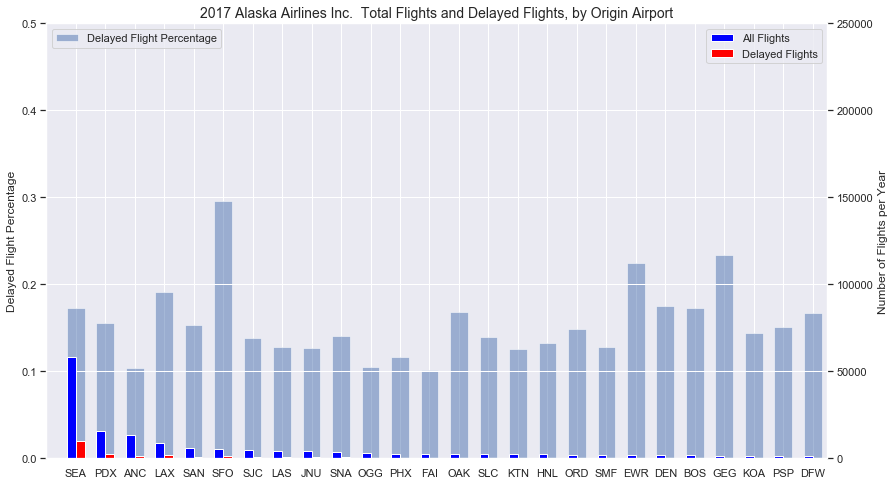

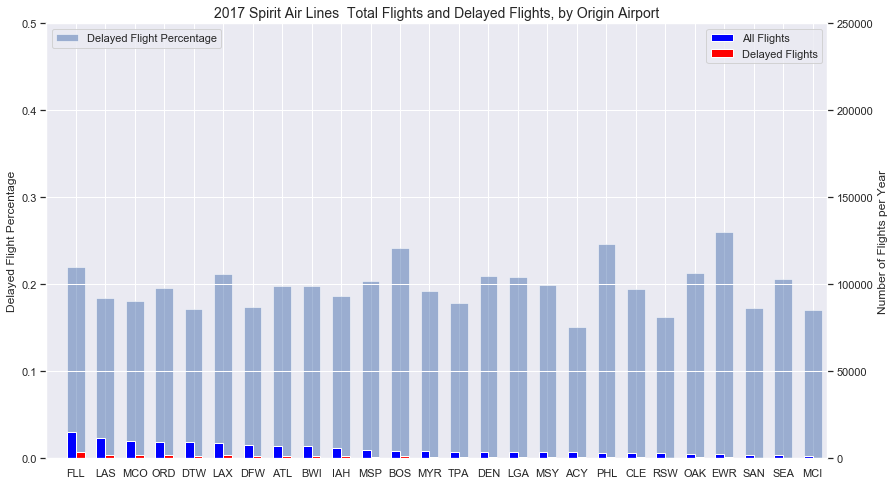

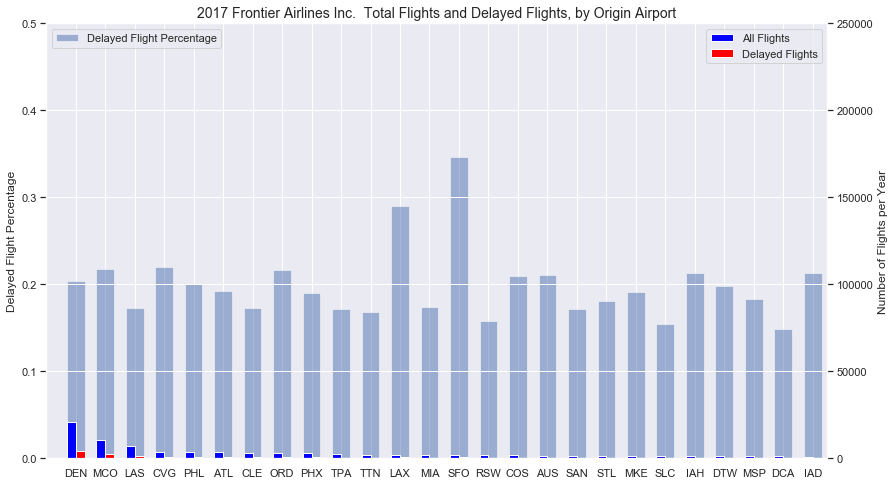

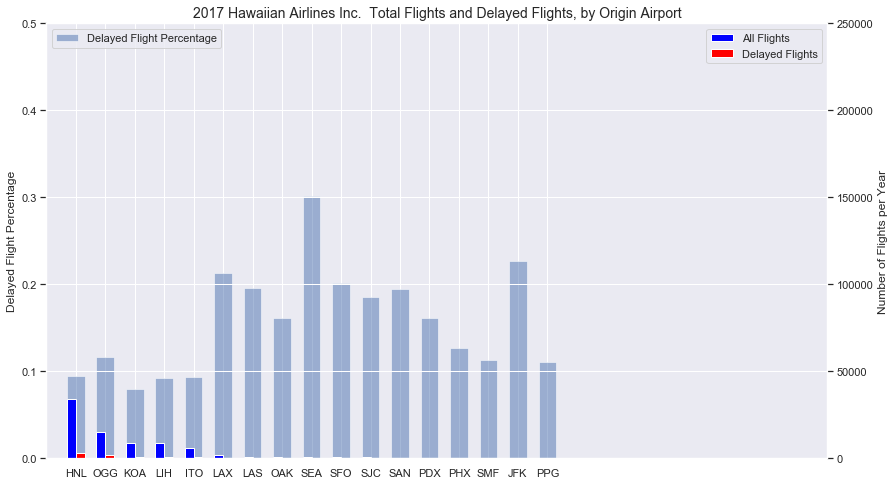

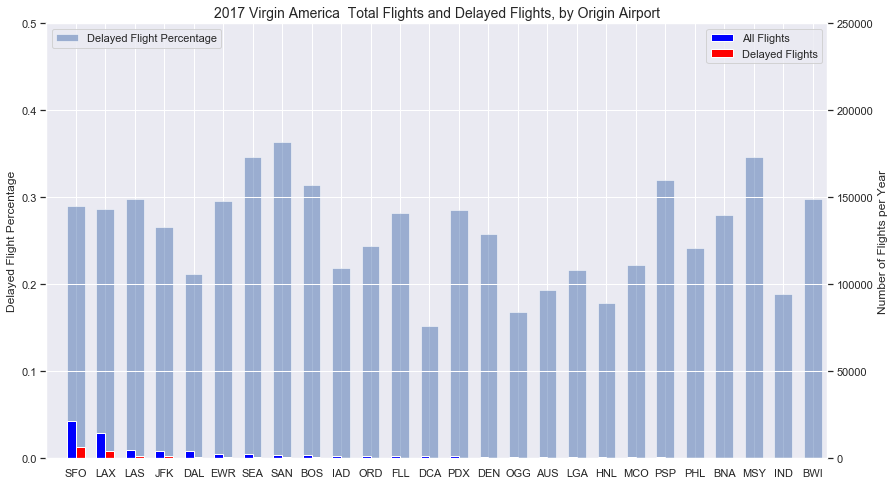

In [30]:
for name in percent_delay.index:
    airline_name=name
    #Let's break the above data down by airline.
    #Most flights are by Southwest and they have a relatively high delay frequency
    airline = df[df.Reporting_Airline == airline_name]
    airline_del = delays_15[delays_15.Reporting_Airline == airline_name]

    airline_byOrigin = airline.groupby('Origin').size().sort_values(ascending=False)[0:60]
    airline_byOrigin_del = airline_del.groupby('Origin').size().sort_values(ascending=False)[0:60]

    indexed_airline = airline.groupby('Origin').size().sort_values(ascending=False).sort_index()
    indexed_airline_del = airline_del.groupby('Origin').size().sort_values(ascending=False).sort_index()
    airline_ratio = indexed_airline_del / indexed_airline
    airline_ratio = airline_ratio.dropna(axis=0)
    delay_ratio = airline_ratio.get(airline_byOrigin.index)

    ####use the same index for all data
    airline_byOrigin_del = airline_byOrigin_del.get(airline_byOrigin.index)
    airline_disp_name = airline_dict.get(airline_name)
    
    ax = plt.subplot(111)
    ax.bar(airline_byOrigin.index, delay_ratio, width=0.6, align='center', alpha=0.5)
    plt.legend(['Delayed Flight Percentage'], loc='upper left')
    plt.ylabel('Delayed Flight Percentage')
    plt.ylim(0, 0.50)

    ax2 = ax.twinx()
    ax2.bar(airline_byOrigin.index, airline_byOrigin, width=-0.3, align='edge', color='blue')
    ax2.bar(airline_byOrigin_del.index, airline_byOrigin_del, width=0.3, align='edge', color='red')
    plt.legend(['All Flights', 'Delayed Flights'])
    plt.xlabel('Origin Airport')
    plt.ylabel('Number of Flights per Year')
    plt.title(f'{year} {airline_disp_name} Total Flights and Delayed Flights, by Origin Airport', fontsize=14)
    plt.xlim(-1,25.5)
    plt.ylim(0,250000)
    plt.show()

### Conclusion and summaries
Above analysis shows that the arrival delay percentage is highly variable and depends on airports and airlines, given all other factors are equal such as weather and traffic.

## Delays by airport

In [169]:
airports = df.groupby('Origin').size().sort_values(ascending=False)[0:40]
airports_del = delays_15.groupby('Origin').size().sort_values(ascending=False)[0:40]

test = df.groupby('Origin').size().sort_values(ascending=False).sort_index()
test_del = delays_15.groupby('Origin').size().sort_values(ascending=False).sort_index()

ratio = test_del / test 
delay_ratio = ratio.get(airports.index)

####use the same index for all data
airports_del = airports_del.get(airports.index)

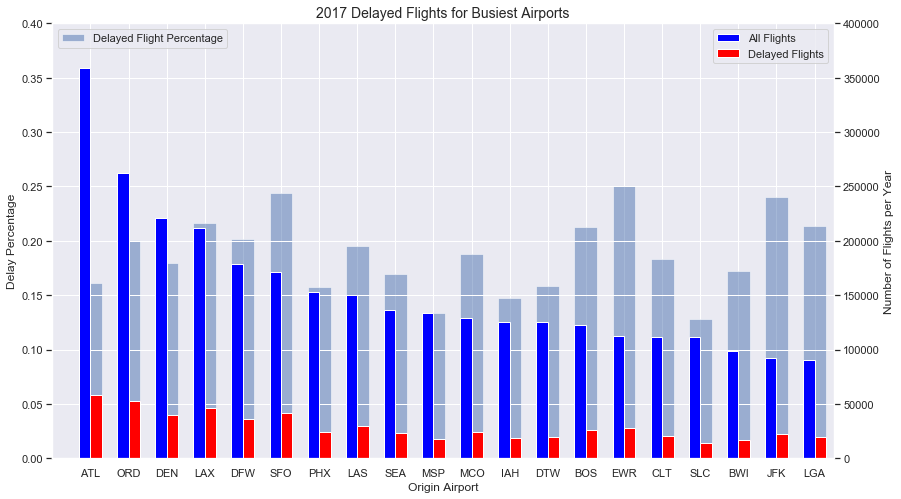

In [170]:
ax = plt.subplot(111)
ax.bar(delay_ratio.keys(), delay_ratio, width=0.6, align='center', alpha=0.5)
plt.ylim(0,0.4)
plt.legend(['Delayed Flight Percentage'], loc='upper left')
plt.xlabel('Origin Airport')
plt.ylabel('Delay Percentage')

ax2 = ax.twinx()
ax2.bar(airports.index, airports, width=-0.3, align='edge', color='blue')
ax2.bar(airports_del.index, airports_del, width=0.3, align='edge', color='red')
plt.legend([ 'All Flights', 'Delayed Flights'])

plt.ylabel('Number of Flights per Year')
plt.title(f'{year} Delayed Flights for Busiest Airports', fontsize=14)
plt.xlim(-1,19.5)
plt.ylim(0,400000)

plt.show()

In [181]:
df.DepDelay.mean()

9.659998996309646

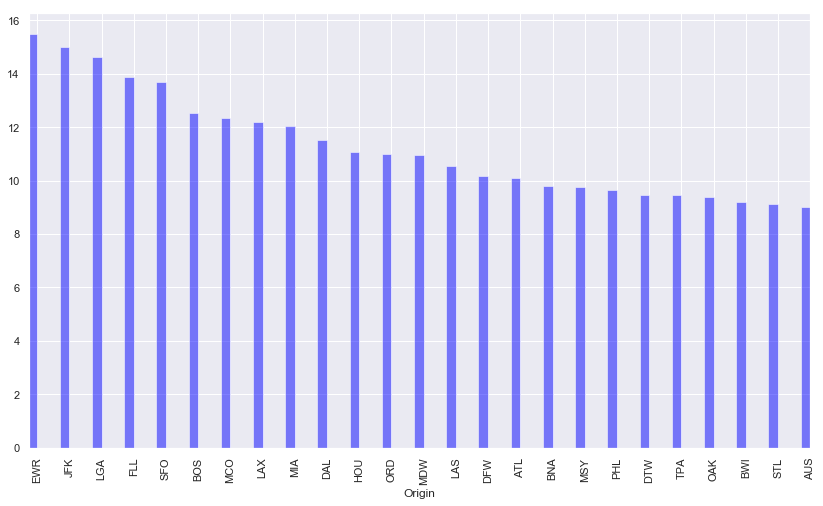

In [191]:
df[df.Origin.isin(airports.index)].groupby('Origin')['DepDelay'].mean()\
.sort_values(ascending=False)[0:25].plot(kind='bar', color='blue', alpha=0.5, width=-0.3, align='edge')
#df[df.Origin.isin(airports.index)].groupby('Origin')['ArrDelay'].mean()\
#.sort_values(ascending=False)[0:25].plot(kind='bar', color='red', alpha=0.5, width=0.3, align='edge')



## Regional Analysis 

In [197]:
#import airport location information csv
airport_location = pd.read_csv('airport_loc.csv')
#combine Latitude and Longitude into a tuple and form a new column and drop the Latitude & Longitude columns
airport_location['location'] = list(zip(airport_location.Latitude, airport_location.Longitude))
airports_locs = airport_location.copy()
airports_locs.head()
airports_locs.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
airport_loc = airports_locs.set_index('locationID').to_dict()['location']

In [194]:
#For regional calculation we'll set up a "radius" around the airport, for that we'll need a custom function
def radius(airport, miles):
    '''This function will return the absolute difference (in degrees) from the original location to the perimeter
    given the distance, and coordinates of the original location'''
    #based on ~69 miles per one degree of latitude
    coordinates = airport_loc.get(airport)
    #get the minimum and maximum latitudes, since latitude doesn't vary dramatically with distance away from equator
    #we can just compute the latitude variance by direct conversion of 69 miles per degree
    lat_var = miles / 69
    min_lat = coordinates[0] - lat_var
    max_lat = coordinates[0] + lat_var
    
    #longitude distance between degrees depends on the latitude, so we'll use the above computed latitudes to 
    #compute the variance in longitude
    long_min = miles / (math.cos(min_lat * math.pi / 180) * 69.172)  
    long_max = miles / (math.cos(max_lat * math.pi / 180) * 69.172)
    
    min_long = coordinates[1] - long_min
    max_long = coordinates[1] + long_max
    
    latitude = [min_lat, max_lat]
    longitude = [min_long, max_long]
    
    return latitude, longitude

In [193]:
def region_airports(airport, miles):
    '''This function takes airport code and distance around it as an input and
    returns a list of airport within the specified distance'''
    coordinates = radius(airport, miles)
    #print(coordinates)
    airports_locs = airport_location.copy()
    airports_locs = airports_locs[(airports_locs.Latitude >= coordinates[0][0]) & (airports_locs.Latitude <= coordinates[0][1]) &
                       (airports_locs.Longitude >= coordinates[1][0]) & (airports_locs.Longitude <= coordinates[1][1])]
    
    unique_list = airports_locs['locationID'].unique()
    return unique_list

Input airport and radius in miles:

In [207]:
#returns a new dataframe with only the Origin airports that are within the specified radius
regional_airports = set(region_airports('JFK', 30))
all_airports = set(df.Origin)
matching_local_airports = list(regional_airports.intersection(all_airports))
#"local" DataFrame only has origin airports
local = df[df.Origin.isin(matching_local_airports)]

In [208]:
matching_local_airports.append('National Average')

Text(0.5, 1.0, 'Selected Region Airport Delays vs National Average Delays')

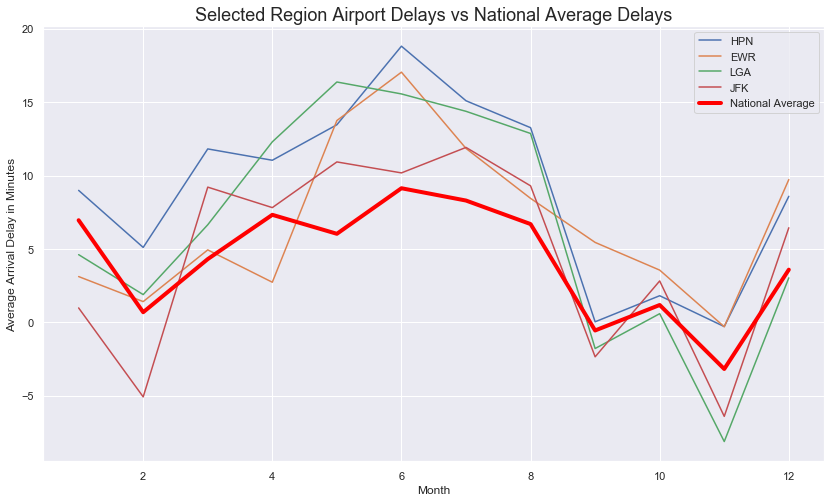

In [209]:
local.groupby(['Month', 'Origin'])['ArrDelay'].mean().unstack().plot()
df.groupby(['Month'])['ArrDelay'].mean().plot(linewidth=4, color='red')
plt.legend(matching_local_airports)
plt.ylabel('Average Arrival Delay in Minutes')
plt.xlabel('Month')
plt.title('Selected Region Airport Delays vs National Average Delays', fontsize=18)

In [210]:
local.groupby("Origin")['ArrDelay'].mean().dropna()

Origin
EWR    9.129261
HPN    7.048213
JFK    6.880571
LGA    4.800042
Name: ArrDelay, dtype: float64

Text(0.5, 1.0, 'Selected Region Airport Delays vs National Average Delays')

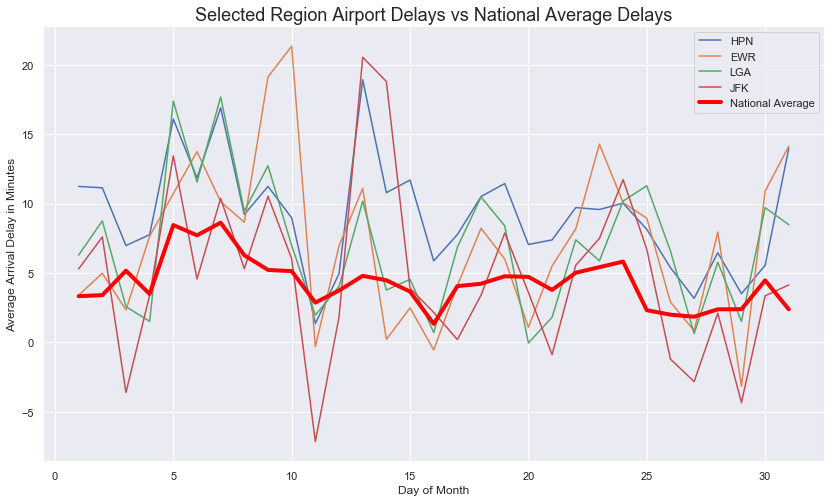

In [211]:
local.groupby(['DayofMonth', 'Origin'])['ArrDelay'].mean().unstack().plot()
df.groupby(['DayofMonth'])['ArrDelay'].mean().plot(linewidth=4, color='red')
plt.legend(matching_local_airports)
plt.ylabel('Average Arrival Delay in Minutes')
plt.xlabel('Day of Month')
plt.title('Selected Region Airport Delays vs National Average Delays', fontsize=18)

Text(0.5, 1.0, 'Selected Region Airport Delays vs National Average Delays')

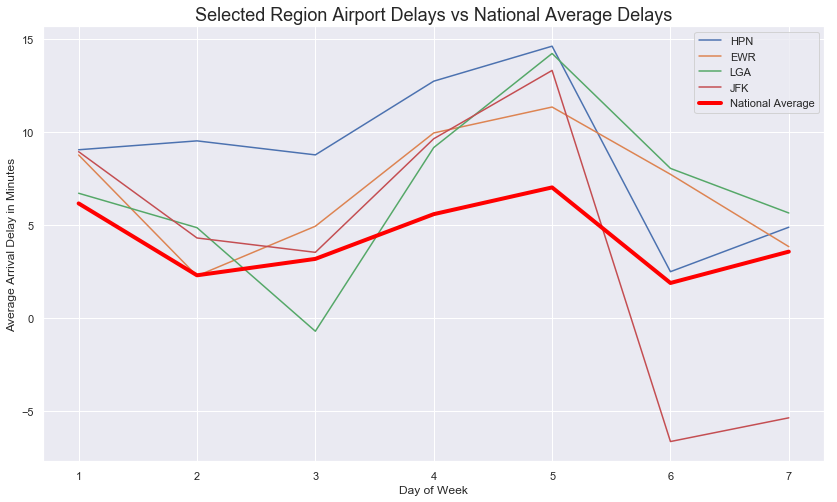

In [212]:
local.groupby(['DayOfWeek', 'Origin'])['ArrDelay'].mean().unstack().plot()
df.groupby(['DayOfWeek'])['ArrDelay'].mean().plot(linewidth=4, color='red')
plt.legend(matching_local_airports)
plt.ylabel('Average Arrival Delay in Minutes')
plt.xlabel('Day of Week')
plt.title('Selected Region Airport Delays vs National Average Delays', fontsize=18)

In [213]:
JFK = local[local.Origin == 'JFK']
EWR = local[local.Origin == 'EWR']
LGA = local[local.Origin == 'LGA']

Text(0.5, 1.0, 'Arrival Delay Distribution')

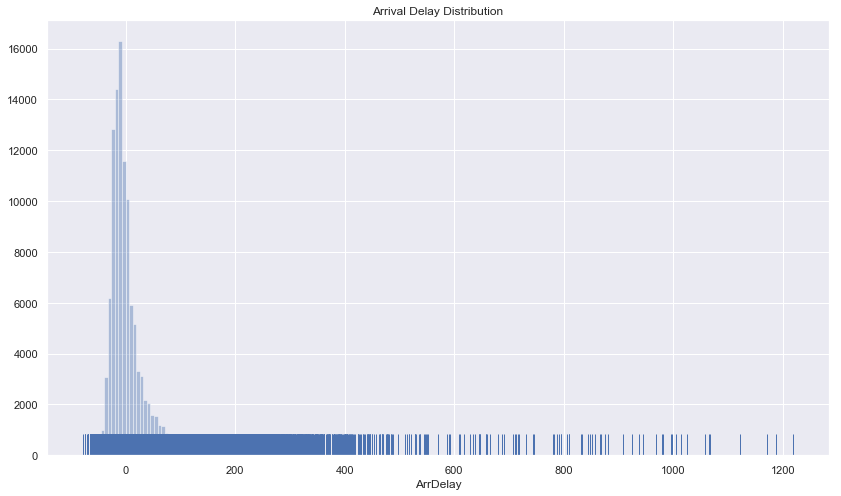

In [214]:
sns.distplot(EWR.ArrDelay, bins=200, kde=False, rug=True)
plt.title('Arrival Delay Distribution')

In [44]:
df.columns

Index(['index', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline',
       'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 'OriginState', 'DestState',
       'Dest', 'CRSDepTime', 'DepTime', 'DepDelay', 'TaxiOut', 'TaxiIn', 'CRSArrTime', 'ArrTime',
       'CRSElapsedTime', 'ArrDelay', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

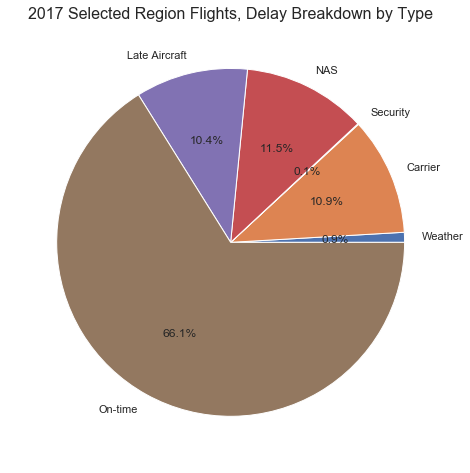

In [215]:
all_flights = local.Month.count()
on_time_df = local[local.ArrDelay <= 15]
delay_df = local[local.ArrDelay > 15]
on_time = on_time_df.Month.count()

weather = delay_df[delay_df.WeatherDelay > 0].count()
carrier = delay_df[delay_df.CarrierDelay > 0].count()
NAS = delay_df[delay_df.NASDelay > 0].count()
security = delay_df[delay_df.SecurityDelay > 0].count()
late_aircraft = delay_df[delay_df.LateAircraftDelay > 0].count()

weather_percent = weather.Month / all_flights
carrier_percent = carrier.Month / all_flights
NAS_percent = NAS.Month / all_flights
security_percent = security.Month / all_flights
late_aircraft_delay_percent = late_aircraft.Month / all_flights
no_delay_percent = on_time / all_flights

x = [weather_percent, carrier_percent, security_percent, NAS_percent, 
     late_aircraft_delay_percent, no_delay_percent]

plt.pie(x, labels=['Weather', 'Carrier', 'Security', 'NAS', 'Late Aircraft', 'On-time'], autopct='%1.1f%%')
plt.title(f'{year} Selected Region Flights, Delay Breakdown by Type', fontsize=16)
plt.show()

How does this compare to all National Flights in 2017?

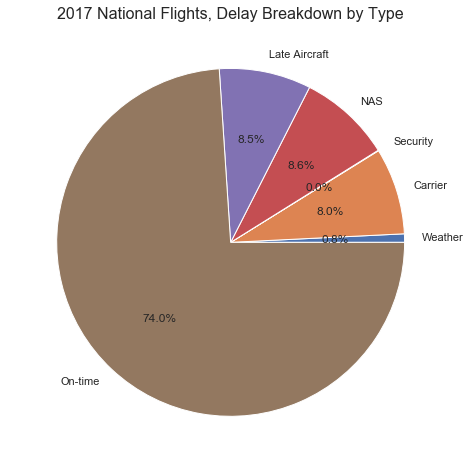

In [129]:
all_flights_nat = df.Month.count()
on_time_df_nat = df[df.ArrDelay <= 15]
delay_df_nat = df[df.ArrDelay > 15]
on_time_nat = on_time_df_nat.Month.count()

weather_nat = delay_df_nat[delay_df_nat.WeatherDelay > 0].count()
carrier_nat = delay_df_nat[delay_df_nat.CarrierDelay > 0].count()
NAS_nat = delay_df_nat[delay_df_nat.NASDelay > 0].count()
security_nat = delay_df_nat[delay_df_nat.SecurityDelay > 0].count()
late_aircraft_nat = delay_df_nat[delay_df_nat.LateAircraftDelay > 0].count()

weather_percent_nat = weather_nat.Month / all_flights_nat
carrier_percent_nat = carrier_nat.Month / all_flights_nat
NAS_percent_nat = NAS_nat.Month / all_flights_nat
security_percent_nat = security_nat.Month / all_flights_nat
late_aircraft_delay_percent_nat = late_aircraft_nat.Month / all_flights_nat
no_delay_percent_nat = on_time_nat / all_flights_nat

x = [weather_percent_nat, carrier_percent_nat, security_percent_nat, NAS_percent_nat, 
     late_aircraft_delay_percent_nat, no_delay_percent_nat]

plt.pie(x, labels=['Weather', 'Carrier', 'Security', 'NAS', 'Late Aircraft', 'On-time'], autopct='%1.1f%%')
plt.title(f'{year} National Flights, Delay Breakdown by Type', fontsize=16)
plt.show()

In [46]:
del matching_local_airports[-1]

### FAA has data available for NAS delays, further broken down by category.
https://aspm.faa.gov/opsnet/sys/Delays.asp

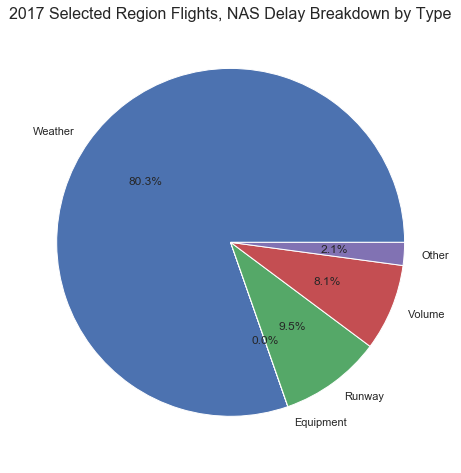

In [216]:
nas_delay = pd.read_csv('NAS_delay.csv')
NAS_by_year = nas_delay[(nas_delay.Year == float(year)) & nas_delay.Facility.isin(matching_local_airports)]
total_time = NAS_by_year.groupby('Facility')['all Total min.'].sum().sort_index()
volume_time = NAS_by_year.groupby('Facility')['volume total'].sum().sort_index()
equipment_time = NAS_by_year.groupby('Facility')['Equipment total'].sum().sort_index()
runway_time = NAS_by_year.groupby('Facility')['runway total'].sum().sort_index()
other_time = NAS_by_year.groupby('Facility')['other total'].sum().sort_index()
weather_time = NAS_by_year.groupby('Facility')['Weather total'].sum().sort_index()

percent_volume = volume_time / total_time
percent_equipment = equipment_time / total_time
percent_runway = runway_time / total_time
percent_other = other_time / total_time
percent_weather = weather_time / total_time

total_time = total_time.sort_values(ascending=False)

percent_volume = percent_volume.get(total_time.index)[0:100]
percent_equipment = percent_equipment.get(total_time.index)[0:100]
percent_runway = percent_runway.get(total_time.index)[0:100]
percent_other = percent_other.get(total_time.index)[0:100]
percent_weather = percent_weather.get(total_time.index)[0:100]

all_weather = weather_time.sum() / total_time.sum()
all_equipment = equipment_time.sum() / total_time.sum()
all_runway = runway_time.sum() / total_time.sum()
all_volume = volume_time.sum() / total_time.sum()
all_other = other_time.sum() / total_time.sum()

x = [all_weather, all_equipment, all_runway, all_volume, all_other]

plt.pie(x, labels=['Weather', 'Equipment', 'Runway', 'Volume', 'Other'], autopct='%1.1f%%')
plt.title(f'{year} Selected Region Flights, NAS Delay Breakdown by Type', fontsize=16)
plt.show()

Weather delay average: 0.22575507840342124 mins.
Carrier delay average: 3.499220420527441 mins.
NAS delay average: 2.756997653837016 mins.
Security delay average: 0.017997148966500356 mins.
Late Aircraft delay average: 6.903699661439772 mins.


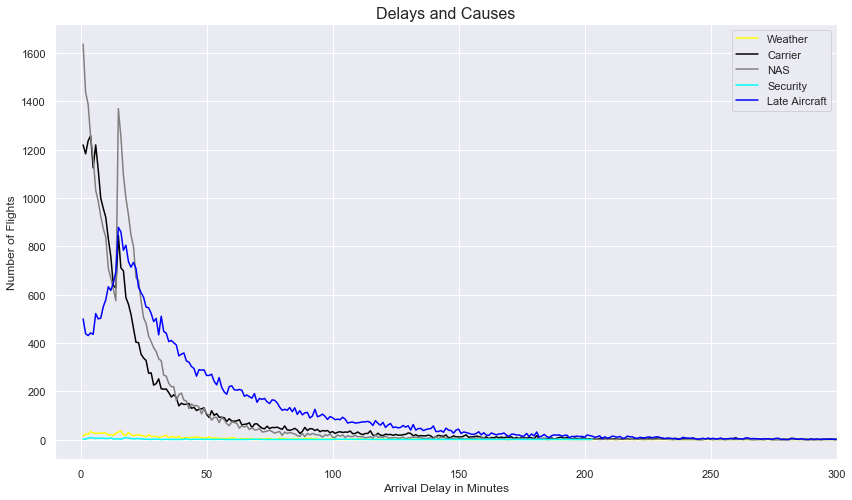

In [48]:
print(f'Weather delay average: {local.WeatherDelay.mean()} mins.')
print(f'Carrier delay average: {local.CarrierDelay.mean()} mins.')
print(f'NAS delay average: {local.NASDelay.mean()} mins.')
print(f'Security delay average: {local.SecurityDelay.mean()} mins.')
print(f'Late Aircraft delay average: {local.LateAircraftDelay.mean()} mins.')

local.groupby('WeatherDelay').size()[1:].plot(color='yellow')
local.groupby('CarrierDelay').size()[1:].plot(color='black')
local.groupby('NASDelay').size()[1:].plot(color='gray')
local.groupby('SecurityDelay').size()[1:].plot(color='cyan')
local.groupby('LateAircraftDelay').size()[1:].plot(color='blue')
plt.xlim(-10,300)
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Number of Flights')
plt.title('Delays and Causes', fontsize=16)
plt.legend(['Weather', 'Carrier', 'NAS', 'Security', 'Late Aircraft'])

NAS - We can continue to look at patterns for heavy traffic or trends in increassing air traffic patterns areas and look for consitancies. Addionally, although extreme events are not considered here, normal weather patterns that cause air traffic slowdowns are. Looking at weather patterns may be beneficial. FAA has a database breaking down the NAS delays by cause. (FAA OPSNET)

Carrier - carrier performance can be further analyzed by location and see if there are patterns

Late Aircraft - This can be handled with arrival delay information. This field highly depends on the other delay causes.

## Evaluating congested times in a selected region

### Do busy times in a given region have a higher arrival delay time?

In [49]:
#define a useful function
def time_to_float(time):
    '''This function will convert time that is incorrectly represented into a float
    for easier plotting with matplotlib'''
    if len(str(int(time))) > 2:
        denom = time / 2400.0
        numer = (float(str(int(time))[:-2:]) + float(str(int(time))[-2:])/60)/24
        ratio = numer / denom
        time_float = time * ratio
    else:
        time_float = time / 60 * 100 
    return time_float

In [217]:
matching_local_airports

['HPN', 'EWR', 'LGA', 'JFK', 'National Average']

In [218]:
#we'll need to consider all arriving and departing traffic in the region to undestand congestion delays
arriving_flights = df[df.Dest.isin(matching_local_airports)]
departing_flights = df[df.Origin.isin(matching_local_airports)]

In [219]:
#add columns converting departure and arrival time to hourly increments
arriving_flights['ARR_HOUR'] = arriving_flights['CRSArrTime'].apply(lambda x: int(str(x)[:2]) if x>999 
                                                                  else int(str(x)[:1] if x>99 else 0))
arriving_flights['ARR_HOUR'] = arriving_flights['ARR_HOUR'].apply(lambda x:0 if x==24 else x)
departing_flights['DEP_HOUR'] = departing_flights['CRSDepTime'].apply(lambda x: int(str(x)[:2]) if x>999 
                                                                        else int(str(x)[:1] if x>99 else 0))


/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [220]:
arr_del = pd.DataFrame(arriving_flights.groupby('ARR_HOUR')['ArrDelay'].mean())
dep_del = pd.DataFrame(departing_flights.groupby('DEP_HOUR')['ArrDelay'].mean())

In [54]:
'''#merge arrival delays at departure airport and arriving airport
total_del = pd.merge(arr_del, dep_del, how='left', left_on=arr_del.index, right_on=dep_del.index)
#remove delays that are longer than 90 minutes
total_del['ARR_DELAY_x'] = total_del.ARR_DELAY_x.apply(lambda x: x if x < 90 else 0)
total_del['ARR_DELAY_y'] = total_del.ARR_DELAY_y.apply(lambda x: x if x < 90 else 0)
#create a new column and add the arrival delays at departure airport and arriving airport
total_del['sum'] = total_del['ARR_DELAY_x'] + total_del['ARR_DELAY_y']

total_del.drop(columns=['key_0'])
#rename and sort the index
total_del = total_del.rename(index={0:24})
total_del = total_del.sort_index()'''

"#merge arrival delays at departure airport and arriving airport\ntotal_del = pd.merge(arr_del, dep_del, how='left', left_on=arr_del.index, right_on=dep_del.index)\n#remove delays that are longer than 90 minutes\ntotal_del['ARR_DELAY_x'] = total_del.ARR_DELAY_x.apply(lambda x: x if x < 90 else 0)\ntotal_del['ARR_DELAY_y'] = total_del.ARR_DELAY_y.apply(lambda x: x if x < 90 else 0)\n#create a new column and add the arrival delays at departure airport and arriving airport\ntotal_del['sum'] = total_del['ARR_DELAY_x'] + total_del['ARR_DELAY_y']\n\ntotal_del.drop(columns=['key_0'])\n#rename and sort the index\ntotal_del = total_del.rename(index={0:24})\ntotal_del = total_del.sort_index()"

In [221]:
arr_del.head()

,ArrDelay
ARR_HOUR,
0,10.248765
1,4.510747
2,3.413333
3,-3.333333
4,1.357513


Flights are typically not scheduled to arrive during night time hours. It looks like these flights represent all heavily delayed flights. Let's confirm by plotting histograms for each hour

In [222]:
arr_del = arr_del.rename(index={0:24})

In [223]:
arr_del = arr_del.sort_index()

In [293]:
df['ARR_HOUR'] = df['CRSArrTime'].apply(lambda x: int(str(x)[:2]) if x>999 
                                                                  else int(str(x)[:1] if x>99 else 0))
df['ARR_HOUR'] = df['ARR_HOUR'].apply(lambda x:0 if x==24 else x)

In [294]:
total_del = pd.DataFrame(df.groupby('ARR_HOUR')['ArrDelay'].mean())

In [298]:
total_del = total_del.rename(index={0:24})
total_del = total_del.sort_index()

### Total air traffic dataframe

In [224]:
arr = pd.DataFrame(arriving_flights.groupby('ARR_HOUR').size())
dep = pd.DataFrame(departing_flights.groupby('DEP_HOUR').size())

In [225]:
total = pd.merge(arr, dep, how='left', left_on=arr.index, right_on=dep.index)

In [226]:
total['sum'] = total['0_x'] + total['0_y']

In [227]:
total = total.rename(index={0:24})

In [228]:
total.drop(columns=['key_0'])

,0_x,0_y,sum
24,6480,NaN,NaN
1,977,4.0,981.0
2,75,NaN,NaN
3,3,NaN,NaN
4,386,NaN,NaN
5,7651,3190.0,10841.0
6,7693,21140.0,28833.0
7,12255,22286.0,34541.0
8,12427,24800.0,37227.0
9,13743,19482.0,33225.0


In [229]:
total = total.sort_index()

In [230]:
total = total.fillna(0)

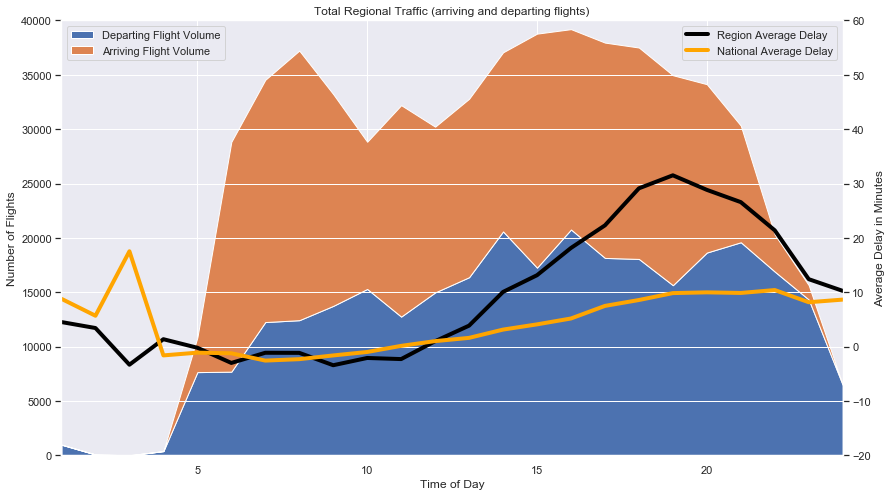

In [306]:
ax = plt.subplot(111)
y = [total['0_x'], total['0_y']]
x = total.index

ax.stackplot(x, y, labels=['Departing Flight Volume','Arriving Flight Volume'])
plt.legend(loc='upper left')
plt.xlabel('Time of Day')
plt.ylabel('Number of Flights')
plt.title('Total Regional Traffic (arriving and departing flights)')
plt.ylim(0,40000)
plt.xlim(1,24)

ax2 = ax.twinx()
ax2.plot(arr_del.index, arr_del['ArrDelay'], color='black', linewidth=4)
ax2.plot(total_del.index, total_del['ArrDelay'], color='orange', linewidth=4)
plt.ylabel('Average Delay in Minutes')
plt.ylim(-20,60)
plt.legend(['Region Average Delay', 'National Average Delay'], loc='upper right')

plt.show()

It looks like delays increase towards the evening hours of the day.

How do airlines perform throughout the week by hour. Is there a time of the week that results in more delays?

In [232]:
#add columns converting departure and arrival time to hourly increments
local['DEP_HOUR'] = local['CRSDepTime'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
local['ARR_HOUR'] = local['CRSArrTime'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [233]:
local_sub = local[['DayOfWeek','DEP_HOUR','Reporting_Airline','ArrDelay']]

In [234]:
local_sub['DayOfWeek'].replace(1,'Monday',inplace=True)
local_sub['DayOfWeek'].replace(2,'Tuesday',inplace=True)
local_sub['DayOfWeek'].replace(3,'Wednesday',inplace=True)
local_sub['DayOfWeek'].replace(4,'Thursday',inplace=True)
local_sub['DayOfWeek'].replace(5,'Friday',inplace=True)
local_sub['DayOfWeek'].replace(6,'Saturday',inplace=True)
local_sub['DayOfWeek'].replace(7,'Sunday',inplace=True)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [235]:
local_sub.head()

,DayOfWeek,DEP_HOUR,Reporting_Airline,ArrDelay
1185,Saturday,12,WN,-21.0
1186,Saturday,16,WN,53.0
1187,Saturday,14,WN,21.0
1188,Saturday,6,WN,-19.0
1189,Saturday,14,WN,6.0


In [236]:
monday = local_sub[local_sub.DayOfWeek == 'Monday']
monday = monday.reset_index()
monday = monday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
monday = monday.groupby('DEP_HOUR').mean()

tuesday = local_sub[local_sub.DayOfWeek == 'Tuesday']
tuesday = tuesday.reset_index()
tuesday = tuesday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
tuesday = tuesday.groupby('DEP_HOUR').mean()

wednesday = local_sub[local_sub.DayOfWeek == 'Wednesday']
wednesday = wednesday.reset_index()
wednesday = wednesday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
wednesday = wednesday.groupby('DEP_HOUR').mean()

thursday = local_sub[local_sub.DayOfWeek == 'Thursday']
thursday = thursday.reset_index()
thursday = thursday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
thursday = thursday.groupby('DEP_HOUR').mean()

friday = local_sub[local_sub.DayOfWeek == 'Friday']
friday = friday.reset_index()
friday = friday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
friday = friday.groupby('DEP_HOUR').mean()

saturday = local_sub[local_sub.DayOfWeek == 'Saturday']
saturday = saturday.reset_index()
saturday = saturday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
saturday = saturday.groupby('DEP_HOUR').mean()

sunday = local_sub[local_sub.DayOfWeek == 'Sunday']
sunday = sunday.reset_index()
sunday = sunday.drop(['index', 'Reporting_Airline', 'DayOfWeek'], axis=1)
sunday = sunday.groupby('DEP_HOUR').mean()

In [276]:
len(thursday)

19

In [252]:
sunday = sunday.drop([1])

In [71]:
thursday.iloc[2]

ArrDelay   -6.294393
Name: 5, dtype: float64

In [277]:
new_df = pd.DataFrame()

In [278]:
new_df['Monday'] = monday.ArrDelay.values
new_df['Tuesday'] = tuesday.ArrDelay.values
new_df['Wednesday'] = wednesday.ArrDelay.values
new_df['Thursday'] = thursday.ArrDelay.values
new_df['Friday'] = friday.ArrDelay.values
new_df['Saturday'] = saturday.ArrDelay.values
new_df['Sunday'] = sunday.ArrDelay.values

In [281]:
monday

,ArrDelay
DEP_HOUR,
5,-9.299228
6,-6.315822
7,-6.194240
8,-4.285563
9,-0.998972
10,-1.055149
11,0.919890
12,3.509549
13,8.571659


In [279]:
new_df = new_df.reset_index()

In [280]:
new_df

,index,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,-9.299228,-10.043750,-9.362525,-6.003937,-9.160156,-6.637097,-6.708738
1,1,-6.315822,-6.488133,-7.324808,-6.375038,-3.911138,-5.108613,-8.961649
2,2,-6.194240,-8.478723,-7.480191,-4.498066,-4.384412,-7.399416,-9.556652
3,3,-4.285563,-3.865400,-3.896863,2.985239,0.660714,-5.213612,-9.117235
4,4,-0.998972,0.052212,-1.416521,4.935920,6.155786,-1.641779,-9.534366
5,5,-1.055149,-1.727318,-3.344611,2.023622,2.240812,-2.420516,-9.881449
6,6,0.919890,-1.574919,-3.364917,1.113043,3.774931,-0.040184,-5.641829
7,7,3.509549,-0.825376,-1.066320,1.658881,4.461171,-3.766962,-7.139800
8,8,8.571659,3.216958,5.094527,3.788469,9.279647,0.377178,-3.904121
9,9,8.128268,2.876419,6.111850,7.130098,8.317202,2.520042,0.281328


In [286]:
line = pd.DataFrame({"index": 0.0, "Monday": 0.0, "Tuesday": 0.0, "Wednesday": 0.0, "Thursday": 0.0,
                 "Friday": 0.0, "Saturday": 0.0, "Sunday": 0.0,}, index=[1.5])
new_df = new_df.append(line, ignore_index=False)
new_df = new_df.sort_index().reset_index(drop=True)

In [287]:
new_df = new_df.drop(columns=['index'])

In [288]:
hour_day = new_df.copy()

In [289]:
hour_day.index = hour_day.index.astype(str)

In [290]:
from bokeh.plotting import figure
from bokeh.io import output_file, show
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter
from bokeh.transform import transform

In [291]:
hour_day.columns.name = 'Day'

test = pd.DataFrame(hour_day.stack(), columns=['ArrDelay']).reset_index()
source = ColumnDataSource(test)

colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors, low=test.ArrDelay.min(), high=test.ArrDelay.max())
heatmap = figure(plot_width=900, plot_height=300, title='Average Flight Delays by Day and Hour for All Airlines',
                 x_range=list(hour_day.index), y_range=list(hour_day.columns))
heatmap.rect(x='level_0', y="Day", width=1, height=1, source=source,
       line_color=None, fill_color=transform('ArrDelay', mapper))


color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(colors)))

heatmap.add_layout(color_bar, 'right')

heatmap.xaxis.axis_label = 'Departure Hour'
heatmap.yaxis.axis_label = 'Day of the Week'

heatmap.axis.axis_line_color = None
heatmap.axis.major_tick_line_color = None
heatmap.axis.major_label_text_font_size = "8pt"
heatmap.axis.major_label_standoff = 0
heatmap.xaxis.major_label_orientation = 1.0

show(heatmap)

We see that Thursday and Friday afternoons seem particularly busy for this region.

<img src="NYC.png">

Why are we seeing more delays on Thursday and Friday evenings? Is there increase in airport traffic? or increase in passenger loading?

## Most Delayed and Most On-Time Routes by Airline (Weighted Average)

In [81]:
#Using Plotly we'll plot most delayed routes by airline
#To plot the data we'll need an account with an API KEY (stored as Environment Variable)
username = os.environ.get('plotlyUSRNAME')
API_KEY = os.environ.get('plotlyAPI_KEY')
import plotly 
plotly.tools.set_credentials_file(username=username, api_key=API_KEY)

In [82]:
#import airport location information csv
airport_loc = pd.read_csv('airport_loc.csv')
airport_loc['Longitude'] = airport_loc.Longitude * -1
airport_loc = airport_loc.set_index('locationID')
airport_loc.head()

,Latitude,Longitude
locationID,,
YUM,32.6686,-114.5991
MQT,46.3497,-87.3873
SCE,40.8500,-77.8487
ECP,30.3553,-85.7991
ADK,51.8781,-176.6461


### United Airlines (Weighted Average)

In [83]:
#Creating a dataframe for United Airlines flights that are on-time or early.
united = df[df.Reporting_Airline == 'UA']

In [84]:
united.head()

,index,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,DestState,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,CRSArrTime,ArrTime,CRSElapsedTime,ArrDelay,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
191438,193831,2,5,31,3,2017-05-31,UA,N24715,3,ORD,IL,CA,SNA,940,933.0,-7.0,18.0,4.0,1208,1153.0,268.0,-15.0,1726.0,7,0.0,0.0,0.0,0.0,0.0
191439,193832,2,5,31,3,2017-05-31,UA,N35204,3,SNA,CA,TX,IAH,1305,1305.0,0.0,7.0,5.0,1817,1759.0,192.0,-18.0,1346.0,6,0.0,0.0,0.0,0.0,0.0
191440,193833,2,5,31,3,2017-05-31,UA,N68802,10,TPA,FL,TX,IAH,855,850.0,-5.0,14.0,12.0,1024,1009.0,149.0,-15.0,787.0,4,0.0,0.0,0.0,0.0,0.0
191441,193834,2,5,31,3,2017-05-31,UA,N452UA,12,IAH,TX,TN,MEM,2045,2038.0,-7.0,18.0,3.0,2219,2200.0,94.0,-19.0,468.0,2,0.0,0.0,0.0,0.0,0.0
191442,193835,2,5,31,3,2017-05-31,UA,N669UA,14,HNL,HI,NJ,EWR,1450,1444.0,-6.0,22.0,12.0,630,607.0,580.0,-23.0,4962.0,11,0.0,0.0,0.0,0.0,0.0


In [85]:
#Adding coordinates to origin and departure airports
#Origin
united['start_lat'] = united.Origin.apply(lambda x: airport_loc.loc[x].Latitude)
united['start_lon'] = united.Origin.apply(lambda x: airport_loc.loc[x].Longitude)
#Destination
united['end_lat'] = united.Dest.apply(lambda x: airport_loc.loc[x].Latitude)
united['end_lon'] = united.Dest.apply(lambda x: airport_loc.loc[x].Longitude)

united.head()

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

,index,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,DestState,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,CRSArrTime,ArrTime,CRSElapsedTime,ArrDelay,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,start_lat,start_lon,end_lat,end_lon
191438,193831,2,5,31,3,2017-05-31,UA,N24715,3,ORD,IL,CA,SNA,940,933.0,-7.0,18.0,4.0,1208,1153.0,268.0,-15.0,1726.0,7,0.0,0.0,0.0,0.0,0.0,41.9808,-87.9067,33.6756,-117.8683
191439,193832,2,5,31,3,2017-05-31,UA,N35204,3,SNA,CA,TX,IAH,1305,1305.0,0.0,7.0,5.0,1817,1759.0,192.0,-18.0,1346.0,6,0.0,0.0,0.0,0.0,0.0,33.6756,-117.8683,29.9844,-95.3414
191440,193833,2,5,31,3,2017-05-31,UA,N68802,10,TPA,FL,TX,IAH,855,850.0,-5.0,14.0,12.0,1024,1009.0,149.0,-15.0,787.0,4,0.0,0.0,0.0,0.0,0.0,27.9756,-82.5333,29.9844,-95.3414
191441,193834,2,5,31,3,2017-05-31,UA,N452UA,12,IAH,TX,TN,MEM,2045,2038.0,-7.0,18.0,3.0,2219,2200.0,94.0,-19.0,468.0,2,0.0,0.0,0.0,0.0,0.0,29.9844,-95.3414,35.0425,-89.9767
191442,193835,2,5,31,3,2017-05-31,UA,N669UA,14,HNL,HI,NJ,EWR,1450,1444.0,-6.0,22.0,12.0,630,607.0,580.0,-23.0,4962.0,11,0.0,0.0,0.0,0.0,0.0,21.3187,-157.9225,40.6925,-74.1686


In [86]:
#create a flight count dataframe for easier look up
flight_cnt = pd.DataFrame(united.groupby(['Origin','Dest']).size())
avg_delay = pd.DataFrame(united.groupby(['Origin', 'Dest'])['ArrDelay'].mean())

In [87]:
#Temporary column containing a tuple of origin and dest
united['temp'] = list(zip(united.Origin, united.Dest))
#Column with count of flights in the specified route
united['cnt'] = united.temp.apply(lambda x: flight_cnt.loc[x][0])
united['avg_del'] = united.temp.apply(lambda x: avg_delay.loc[x][0])

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [109]:
df_flight_paths = united[['start_lat', 'start_lon', 'end_lat', 'end_lon', 
                            'Reporting_Airline', 'Origin', 'Dest', 'cnt','avg_del']]
df_flight_paths = df_flight_paths.rename(columns={'Origin':'airport1','Dest':'airport2',
                                                 'Reporting_Airline':'airline'})
df_flight_paths = df_flight_paths.drop_duplicates(['airport1','airport2'])

In [110]:
df_flight_paths['wt_delay'] = df_flight_paths.cnt * df_flight_paths.avg_del 

In [111]:
#creating a dataframe for most delayed routes
df_flight_paths_del = df_flight_paths.sort_values(['wt_delay'], ascending=False)[0:200]
df_flight_paths_del = df_flight_paths_del.reset_index()

In [112]:
#creating a dataframe for most on-time routes
df_flight_paths_ontime = df_flight_paths.sort_values(['wt_delay'])[0:200]
df_flight_paths_ontime['wt_delay'] = df_flight_paths_ontime['wt_delay'] * -1
df_flight_paths_ontime = df_flight_paths_ontime.reset_index()

In [132]:
df_flight_paths_ontime.head()

,index,start_lat,start_lon,end_lat,end_lon,airline,airport1,airport2,cnt,avg_del,wt_delay
0,191628,33.9425,-118.4072,38.9475,-77.4600,UA,LAX,IAD,2457,-6.881563,16908.0
1,192105,33.9425,-118.4072,29.9844,-95.3414,UA,LAX,IAH,3556,-3.771372,13411.0
2,191445,39.8617,-104.6731,29.9844,-95.3414,UA,DEN,IAH,3625,-3.664552,13284.0
3,191673,38.8522,-77.0378,29.9844,-95.3414,UA,DCA,IAH,1478,-8.714479,12880.0
4,191512,32.7336,-117.1897,39.8617,-104.6731,UA,SAN,DEN,1557,-8.271676,12879.0


In [133]:
df_flight_paths_del.head()

,index,start_lat,start_lon,end_lat,end_lon,airline,airport1,airport2,cnt,avg_del,wt_delay
0,191501,41.9808,-87.9067,37.6189,-122.3750,UA,ORD,SFO,4397,14.556516,64005.0
1,191544,39.8617,-104.6731,37.6189,-122.3750,UA,DEN,SFO,3912,14.054448,54981.0
2,191487,40.6925,-74.1686,37.6189,-122.3750,UA,EWR,SFO,4885,10.128557,49478.0
3,191695,41.9808,-87.9067,40.6925,-74.1686,UA,ORD,EWR,3151,15.589971,49124.0
4,192281,40.6925,-74.1686,42.3631,-71.0064,UA,EWR,BOS,3069,14.160964,43460.0


In [94]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()


airports = [go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = go.scattergeo.Marker(
        size = 2,
        color = 'rgb(0, 0, 255)',
        line = go.scattergeo.marker.Line(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    ))]

flight_paths = []
for i in range(len(df_flight_paths_del)):
    flight_paths.append(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flight_paths_del['start_lon'][i], df_flight_paths_del['end_lon'][i]],
            lat = [df_flight_paths_del['start_lat'][i], df_flight_paths_del['end_lat'][i]],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = 'blue',
            ),
            opacity = float(df_flight_paths_del['cnt'][i]) / float(df_flight_paths_del['cnt'].max()),
        )
    )

layout = go.Layout(
    title = go.layout.Title(
        text = '2017 United Airlines Most Delayed Routes (weighted average)'
    ),
    
    showlegend = False,
    geo = go.layout.Geo(
        #resolution = 50,
        showlakes = True,
        scope = 'north america',
        projection = go.layout.geo.Projection(type = 'azimuthal equal area'),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig = go.Figure(data = flight_paths + airports, layout = layout)
py.iplot(fig, filename = 'United_Most_Delayed_Routes')

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [95]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()


airports = [go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = go.scattergeo.Marker(
        size = 2,
        color = 'rgb(0, 0, 255)',
        line = go.scattergeo.marker.Line(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    ))]

flight_paths = []
for i in range(len(df_flight_paths_ontime)):
    flight_paths.append(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flight_paths_ontime['start_lon'][i], df_flight_paths_ontime['end_lon'][i]],
            lat = [df_flight_paths_ontime['start_lat'][i], df_flight_paths_ontime['end_lat'][i]],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = 'blue',
            ),
            opacity = float(df_flight_paths_ontime['cnt'][i]) / float(df_flight_paths_ontime['cnt'].max()),
        )
    )

layout = go.Layout(
    title = go.layout.Title(
        text = '2017 United Airlines Most On-Time Routes (weighted average)'
    ),
    
    showlegend = False,
    geo = go.layout.Geo(
        #resolution = 50,
        showlakes = True,
        scope = 'north america',
        projection = go.layout.geo.Projection(type = 'azimuthal equal area'),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig = go.Figure(data = flight_paths + airports, layout = layout)
py.iplot(fig, filename = 'United_Most_On-Time_Routes')

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



#### Delayed most common airport origin and destination

In [128]:
df_flight_paths_del.head()

,index,start_lat,start_lon,end_lat,end_lon,airline,airport1,airport2,cnt,avg_del,wt_delay
0,191501,41.9808,-87.9067,37.6189,-122.3750,UA,ORD,SFO,4397,14.556516,64005.0
1,191544,39.8617,-104.6731,37.6189,-122.3750,UA,DEN,SFO,3912,14.054448,54981.0
2,191487,40.6925,-74.1686,37.6189,-122.3750,UA,EWR,SFO,4885,10.128557,49478.0
3,191695,41.9808,-87.9067,40.6925,-74.1686,UA,ORD,EWR,3151,15.589971,49124.0
4,192281,40.6925,-74.1686,42.3631,-71.0064,UA,EWR,BOS,3069,14.160964,43460.0


In [123]:
df_flight_paths_del.groupby(['airport1']).size().sort_values(ascending=False)[0:5]

airport1
EWR    37
SFO    31
ORD    26
IAH    13
IAD     8
dtype: int64

In [119]:
df_flight_paths_del.groupby('airport2').size().sort_values(ascending=False)[0:5]

airport2
EWR    37
SFO    34
ORD    16
LAX     7
HNL     6
dtype: int64

#### On-time most common airport origin and destination

In [125]:
df_flight_paths_ontime.head()

,index,start_lat,start_lon,end_lat,end_lon,airline,airport1,airport2,cnt,avg_del,wt_delay
0,191628,33.9425,-118.4072,38.9475,-77.4600,UA,LAX,IAD,2457,-6.881563,16908.0
1,192105,33.9425,-118.4072,29.9844,-95.3414,UA,LAX,IAH,3556,-3.771372,13411.0
2,191445,39.8617,-104.6731,29.9844,-95.3414,UA,DEN,IAH,3625,-3.664552,13284.0
3,191673,38.8522,-77.0378,29.9844,-95.3414,UA,DCA,IAH,1478,-8.714479,12880.0
4,191512,32.7336,-117.1897,39.8617,-104.6731,UA,SAN,DEN,1557,-8.271676,12879.0


In [117]:
df_flight_paths_ontime.groupby('airport1').size().sort_values(ascending=False)[0:5]

airport1
DEN    35
LAX    12
IAH    11
IAD     8
ORD     7
dtype: int64

In [120]:
df_flight_paths_ontime.groupby('airport2').size().sort_values(ascending=False)[0:5]

airport2
DEN    50
IAH    27
ORD    24
IAD    13
LAX     6
dtype: int64

### Delta Airlines (Weighted Average)

In [96]:
#Creating a dataframe for United Airlines flights that are on-time or early.
delta = df[df.Reporting_Airline == 'DL']

In [97]:
delta.head()

,index,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,DestState,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,CRSArrTime,ArrTime,CRSElapsedTime,ArrDelay,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
105148,107195,2,5,1,1,2017-05-01,DL,N67171,2,JFK,NY,CA,SAN,1907,1936.0,29.0,27.0,3.0,2225,2243.0,378.0,18.0,2446.0,10,7.0,0.0,0.0,0.0,11.0
105149,107196,2,5,1,1,2017-05-01,DL,N3754A,4,LAS,NV,NY,JFK,1015,1250.0,155.0,38.0,13.0,1826,2101.0,311.0,155.0,2248.0,9,0.0,0.0,155.0,0.0,0.0
105150,107197,2,5,1,1,2017-05-01,DL,N394DA,6,LAX,CA,UT,SLC,1025,1056.0,31.0,14.0,4.0,1316,1340.0,111.0,24.0,590.0,3,11.0,0.0,0.0,0.0,13.0
105151,107198,2,5,1,1,2017-05-01,DL,N394DA,7,SLC,UT,CA,LAX,836,901.0,25.0,25.0,6.0,940,957.0,124.0,17.0,590.0,3,0.0,0.0,17.0,0.0,0.0
105152,107199,2,5,1,1,2017-05-01,DL,N952DN,10,DEN,CO,MN,MSP,1805,1800.0,-5.0,12.0,4.0,2104,2048.0,119.0,-16.0,680.0,3,0.0,0.0,0.0,0.0,0.0


In [98]:
#Adding coordinates to origin and departure airports
#Origin
delta['start_lat'] = delta.Origin.apply(lambda x: airport_loc.loc[x].Latitude)
delta['start_lon'] = delta.Origin.apply(lambda x: airport_loc.loc[x].Longitude)
#Destination
delta['end_lat'] = delta.Dest.apply(lambda x: airport_loc.loc[x].Latitude)
delta['end_lon'] = delta.Dest.apply(lambda x: airport_loc.loc[x].Longitude)

delta.head()

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

,index,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,DestState,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,CRSArrTime,ArrTime,CRSElapsedTime,ArrDelay,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,start_lat,start_lon,end_lat,end_lon
105148,107195,2,5,1,1,2017-05-01,DL,N67171,2,JFK,NY,CA,SAN,1907,1936.0,29.0,27.0,3.0,2225,2243.0,378.0,18.0,2446.0,10,7.0,0.0,0.0,0.0,11.0,40.6397,-73.7789,32.7336,-117.1897
105149,107196,2,5,1,1,2017-05-01,DL,N3754A,4,LAS,NV,NY,JFK,1015,1250.0,155.0,38.0,13.0,1826,2101.0,311.0,155.0,2248.0,9,0.0,0.0,155.0,0.0,0.0,36.0800,-115.1522,40.6397,-73.7789
105150,107197,2,5,1,1,2017-05-01,DL,N394DA,6,LAX,CA,UT,SLC,1025,1056.0,31.0,14.0,4.0,1316,1340.0,111.0,24.0,590.0,3,11.0,0.0,0.0,0.0,13.0,33.9425,-118.4072,40.7883,-111.9778
105151,107198,2,5,1,1,2017-05-01,DL,N394DA,7,SLC,UT,CA,LAX,836,901.0,25.0,25.0,6.0,940,957.0,124.0,17.0,590.0,3,0.0,0.0,17.0,0.0,0.0,40.7883,-111.9778,33.9425,-118.4072
105152,107199,2,5,1,1,2017-05-01,DL,N952DN,10,DEN,CO,MN,MSP,1805,1800.0,-5.0,12.0,4.0,2104,2048.0,119.0,-16.0,680.0,3,0.0,0.0,0.0,0.0,0.0,39.8617,-104.6731,44.8819,-93.2217


In [99]:
#create a flight count dataframe for easier look up
flight_cnt = pd.DataFrame(delta.groupby(['Origin','Dest']).size())
avg_delay = pd.DataFrame(delta.groupby(['Origin', 'Dest'])['ArrDelay'].mean())

In [100]:
#Temporary column containing a tuple of origin and dest
delta['temp'] = list(zip(delta.Origin, delta.Dest))
#Column with count of flights in the specified route
delta['cnt'] = delta.temp.apply(lambda x: flight_cnt.loc[x][0])
delta['avg_del'] = delta.temp.apply(lambda x: avg_delay.loc[x][0])

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [101]:
df_flight_paths = delta[['start_lat', 'start_lon', 'end_lat', 'end_lon', 
                            'Reporting_Airline', 'Origin', 'Dest', 'cnt','avg_del']]
df_flight_paths = df_flight_paths.rename(columns={'Origin':'airport1','Dest':'airport2',
                                                 'Reporting_Airline':'airline'})
df_flight_paths = df_flight_paths.drop_duplicates(['airport1','airport2'])

In [102]:
df_flight_paths['wt_delay'] = df_flight_paths.cnt * df_flight_paths.avg_del 

In [103]:
#creating a dataframe for most delayed routes
df_flight_paths_del = df_flight_paths.sort_values(['wt_delay'], ascending=False)[0:200]
df_flight_paths_del = df_flight_paths_del.reset_index()

In [104]:
#creating a dataframe for most on-time routes
df_flight_paths_ontime = df_flight_paths.sort_values(['wt_delay'])[0:200]
df_flight_paths_ontime['wt_delay'] = df_flight_paths_ontime['wt_delay'] * -1
df_flight_paths_ontime = df_flight_paths_ontime.reset_index()

In [105]:
df_flight_paths_ontime.head()

,index,start_lat,start_lon,end_lat,end_lon,airline,airport1,airport2,cnt,avg_del,wt_delay
0,105252,44.8819,-93.2217,33.6367,-84.4281,DL,MSP,ATL,3823,-6.017002,23003.0
1,105748,44.8819,-93.2217,33.4342,-112.0117,DL,MSP,PHX,1860,-9.084409,16897.0
2,106023,44.8819,-93.2217,38.8522,-77.0378,DL,MSP,DCA,1942,-8.617405,16735.0
3,105872,39.9981,-82.8919,33.6367,-84.4281,DL,CMH,ATL,2757,-6.038085,16647.0
4,105466,47.4500,-122.3117,44.8819,-93.2217,DL,SEA,MSP,2187,-7.159122,15657.0


In [106]:
df_flight_paths_del.head()

,index,start_lat,start_lon,end_lat,end_lon,airline,airport1,airport2,cnt,avg_del,wt_delay
0,105410,33.6367,-84.4281,40.6925,-74.1686,DL,ATL,EWR,3616,16.362555,59167.0
1,105524,33.6367,-84.4281,40.7772,-73.8725,DL,ATL,LGA,5435,7.620423,41417.0
2,105254,33.6367,-84.4281,40.6397,-73.7789,DL,ATL,JFK,2418,14.617452,35345.0
3,107812,42.3631,-71.0064,40.7772,-73.8725,DL,BOS,LGA,1730,19.277457,33350.0
4,105343,28.4294,-81.3089,40.6397,-73.7789,DL,MCO,JFK,1689,18.152753,30660.0


In [107]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()


airports = [go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = go.scattergeo.Marker(
        size = 2,
        color = 'green',
        line = go.scattergeo.marker.Line(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    ))]

flight_paths = []
for i in range(len(df_flight_paths_del)):
    flight_paths.append(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flight_paths_del['start_lon'][i], df_flight_paths_del['end_lon'][i]],
            lat = [df_flight_paths_del['start_lat'][i], df_flight_paths_del['end_lat'][i]],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = 'green',
            ),
            opacity = float(df_flight_paths_del['cnt'][i]) / float(df_flight_paths_del['cnt'].max()),
        )
    )

layout = go.Layout(
    title = go.layout.Title(
        text = '2017 Delta Airlines Most Delayed Routes (weighted average)'
    ),
    
    showlegend = False,
    geo = go.layout.Geo(
        #resolution = 50,
        showlakes = True,
        scope = 'north america',
        projection = go.layout.geo.Projection(type = 'azimuthal equal area'),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig = go.Figure(data = flight_paths + airports, layout = layout)
py.iplot(fig, filename = 'Delta_Most_Delayed_Routes')

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [108]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_airports.head()


airports = [go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = go.scattergeo.Marker(
        size = 2,
        color = 'green',
        line = go.scattergeo.marker.Line(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    ))]

flight_paths = []
for i in range(len(df_flight_paths_ontime)):
    flight_paths.append(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flight_paths_ontime['start_lon'][i], df_flight_paths_ontime['end_lon'][i]],
            lat = [df_flight_paths_ontime['start_lat'][i], df_flight_paths_ontime['end_lat'][i]],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = 'green',
            ),
            opacity = float(df_flight_paths_ontime['cnt'][i]) / float(df_flight_paths_ontime['cnt'].max()),
        )
    )

layout = go.Layout(
    title = go.layout.Title(
        text = '2017 Delta Airlines Most On-Time Routes (weighted average)'
    ),
    
    showlegend = False,
    geo = go.layout.Geo(
        #resolution = 50,
        showlakes = True,
        scope = 'north america',
        projection = go.layout.geo.Projection(type = 'azimuthal equal area'),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig = go.Figure(data = flight_paths + airports, layout = layout)
py.iplot(fig, filename = 'Delta_Most_On-Time_Routes')

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Compare NYC-Bay Area flights (and back)

We already concluded that EWR, JFK, and SFO have a higher percentage of delayed flights than other airports. We also see that these routes tend to be most problematic for United Airlines. In this section we'll try to uncover if it's a particular route or the airports themselves that are the issue.

In [141]:
#let's create a dataframe containing all the Bay Area origin airports and NYC destination airports
sfnyc = df[((df.Origin == 'EWR') | (df.Origin == 'JFK') | (df.Origin == 'LGA')) &
           ((df.Dest == 'SFO') | (df.Dest == 'SJC') | (df.Dest == 'OAK'))]

In [143]:
sfnyc.head()

,index,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,DestState,Dest,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,CRSArrTime,ArrTime,CRSElapsedTime,ArrDelay,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
59582,60687,2,5,1,1,2017-05-01,AS,N594AS,783,EWR,NJ,CA,SJC,1605,1557.0,-8.0,15.0,4.0,1940,1930.0,395.0,-10.0,2548.0,11,0.0,0.0,0.0,0.0,0.0
60090,61197,2,5,2,2,2017-05-02,AS,N506AS,783,EWR,NJ,CA,SJC,1605,1613.0,8.0,17.0,3.0,1940,1916.0,395.0,-24.0,2548.0,11,0.0,0.0,0.0,0.0,0.0
60596,61707,2,5,3,3,2017-05-03,AS,N590AS,783,EWR,NJ,CA,SJC,1605,1555.0,-10.0,20.0,3.0,1940,1852.0,395.0,-48.0,2548.0,11,0.0,0.0,0.0,0.0,0.0
61115,62229,2,5,4,4,2017-05-04,AS,N492AS,783,EWR,NJ,CA,SJC,1605,1602.0,-3.0,28.0,3.0,1940,1909.0,395.0,-31.0,2548.0,11,0.0,0.0,0.0,0.0,0.0
61637,62753,2,5,5,5,2017-05-05,AS,N440AS,783,EWR,NJ,CA,SJC,1605,1625.0,20.0,34.0,3.0,1940,1932.0,395.0,-8.0,2548.0,11,0.0,0.0,0.0,0.0,0.0


In [166]:
sfnyc.groupby('Reporting_Airline')['ArrDelay'].mean()

Reporting_Airline
AA    11.469613
AS    -6.110714
B6    11.198219
DL     6.326230
UA    10.158494
VX    17.181271
WN    -0.347826
Name: ArrDelay, dtype: float64

In [161]:
sfnyc.groupby('Reporting_Airline').size()

Reporting_Airline
AA    1629
AS     280
B6    2583
DL    2440
UA    5180
VX    2990
WN      69
dtype: int64

In [155]:
df[(df.Origin == 'EWR') | (df.Origin == 'JFK') | (df.Origin == 'LGA')].Month.count()

294896